### Final Modeling

#### About the Model: 

The following data pipeline and regression model predicts nickel price (price per ton??) for one and two years ahead of time based on 3 features: 

- 1) Nickel prices of 2 years prior to "today's" date
- 2) Current GDP growth rate percentage of China 
- 3) Current global nickel production (in ?? Units) 

#### Recommendations/Disclaimer: 
This model was created as an analytical/exploratory tool to build upon knowledge built from other tools as well. It would be extremely unrealistic to use this tool as a literal forecast and the methods used for final business decisions should be an integrative/cummulative one. 

#### Model Assumptions: 

The model assumes that there is a relationship between nickel price and previous nickel prices around that time. We realize there will be trends missed from behavior economic trends. 

Final model to include these features: 
- 



#### Performance Evaluation: 

- The model is built using data from the preceeding 15 years (, and is tested on the year after that's performance.  

FINAL MODEL: 
- Staggered over JUST 2 years
- over 15 years? 
- Features -- Global nickel production

NEXT STEPS to include:
- Running model and evaluating results 
- Constructing CONFIDENCE INTERVALS OF RESULTS
- Final graphs of predictions


- OUTPUT CSV which includes timestamp of predictions 
- Check MAE over previous 3 years


### Additional Features: 

#### - df['week_of_year'] = df.index.weekofyear 
#### - df['day_of_month'] = df.index.day

#### - GDP per capita and GDP Growth - China https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=CN
#### - China consumption expenditure per GDP 
#### - Global production



In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import os

from sklearn.utils import resample
import numpy as np

rcParams['figure.figsize'] = 9, 6

import glob

import datetime

In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)




### Preprocessing of nickel price (LME), nickel global production (USGS Annual Reports), China GDP per capita and growth (World Bank) 

- Nickel global production link: https://www.usgs.gov/centers/nmic/nickel-statistics-and-information
- GDP China link: https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=CN

In [3]:

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']

LME_futures = LME_futures.iloc[:, 1:]
#LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()

LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()

inventory = LME_futures.iloc[:, 1]
inventory = inventory.astype(float)
inventory = inventory.resample('B').mean()

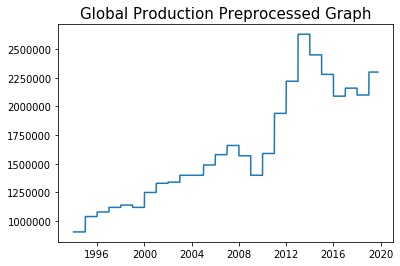

In [4]:
global_production = pd.read_excel('forecasting_raw_data/nickel_features/nickel_extracted.xlsx')
date_index = [datetime.datetime(year, 1, 1) for year in range(1994, 2021)]
series = list(global_production.iloc[:, 1])
series.append(np.nan)

global_production = pd.DataFrame({'global_prod': series})
global_production.index = date_index


global_production = global_production.resample('B').ffill()
upsampled_prod = global_production.interpolate(method='linear')

upsampled_prod = upsampled_prod.dropna()
upsampled_prod = upsampled_prod.loc[:LME.index[-1], :]

LME = LME[upsampled_prod.index]
plt.plot(upsampled_prod)
plt.title('Global Production Preprocessed Graph', fontsize=15)
plt.show()

In [5]:
# NEW CHINA GDP! 

files = glob.glob('forecasting_raw_data/china_data/*' + ".csv")

china = pd.DataFrame()
print('GDP Data Files')
for file in files:
    print(file)
    df = pd.read_csv(file, header=2)
    china_row = df[df['Country Name'] == 'China' ]
    
    
    
    china = china.append(china_row)
    #print(china_row)
    
china.index = china['Indicator Name']
china = china.loc[:, '1961':]
china = china.T
china = china.dropna(how='all')


#china.to_csv('china_gdp_consumption_summary.csv')

new_index = []
for item in china.index:
    new_index.append(datetime.datetime(int(item), 12, 31))
    
china.index = new_index

china_consump = china[['Final consumption expenditure (current US$)', 'Final consumption expenditure (% of GDP)']]
china_gdp = china[['GDP per capita (current US$)', 'GDP per capita growth (annual %)']]

# Manually create current year in dataframe with NaN values

# For China consump

df2 = pd.DataFrame([[np.nan, np.nan]], columns=china_consump.columns)
df2.index = [datetime.datetime(china_consump.index[-1].year+1, 12, 31)]

china_consump = china_consump.append(df2)

# For china gdp

df2 = pd.DataFrame([[np.nan, np.nan]], columns=china_gdp.columns)
df2.index = [datetime.datetime(china_gdp.index[-1].year+1, 12, 31)]

china_gdp = china_gdp.append(df2)




GDP Data Files
forecasting_raw_data/china_data\API_NE.CON.TOTL.CD_DS2_en_csv_v2_427575.csv
forecasting_raw_data/china_data\API_NE.CON.TOTL.ZS_DS2_en_csv_v2_427582.csv
forecasting_raw_data/china_data\API_NY.GDP.PCAP.CD_DS2_en_csv_v2_422141.csv
forecasting_raw_data/china_data\API_NY.GDP.PCAP.KD.ZG_DS2_en_csv_v2_422038.csv


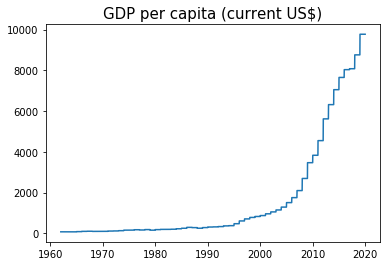

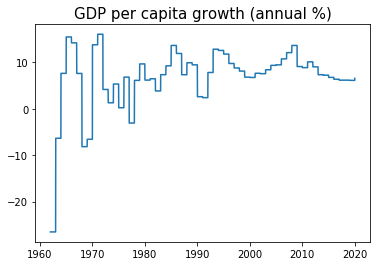

Indicator Name,GDP per capita (current US$),GDP per capita growth (annual %)
1961-12-29,NaN,NaN
1962-01-01,75.805838,-26.527644
1962-01-02,75.805838,-26.527644
1962-01-03,75.805838,-26.527644
1962-01-04,75.805838,-26.527644


In [6]:
# Forward fill using the linear method will fill in the missing value linearly for CURRENT YEAR

# Tail end fill question
# https://stackoverflow.com/questions/48000804/pandas-extrapolate-missing-values-at-the-tail


china_gdp = china_gdp.resample('B').ffill()
upsampled_china = china_gdp.interpolate(method='spline',  limit_direction ='forward', order=2)


for i in range(len(upsampled_china.columns)):

    plt.plot(upsampled_china.iloc[:, i])
    plt.title(str(upsampled_china.columns[i]), fontsize=15)
    plt.show()
    
upsampled_china.head()

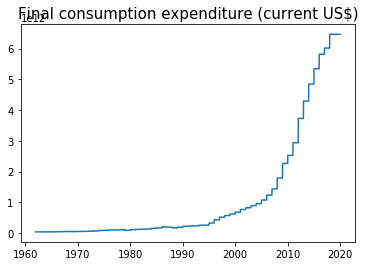

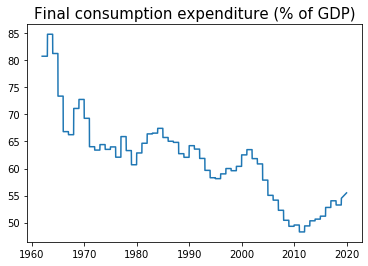

Indicator Name,Final consumption expenditure (current US$),Final consumption expenditure (% of GDP)
1961-12-29,NaN,NaN
1962-01-01,4.042164e+10,80.75144
1962-01-02,4.042164e+10,80.75144
1962-01-03,4.042164e+10,80.75144
1962-01-04,4.042164e+10,80.75144


In [7]:
china_consump = china_consump.resample('B').ffill()
upsampled_china_consump = china_consump.interpolate(method='spline', limit_direction='forward', order=2)


for i in range(len(upsampled_china_consump.columns)):

    plt.plot(upsampled_china_consump.iloc[:, i])
    plt.title(str(upsampled_china_consump.columns[i]), fontsize=15)
    plt.show()
    
upsampled_china_consump.head()

# upsampled_china_consump[upsampled_china_consump.index.day == 1]

In [8]:
upsampled_china = upsampled_china.loc[upsampled_prod.index, :]
upsampled_china

upsampled_china_consump = upsampled_china_consump.loc[upsampled_prod.index, :]
upsampled_china_consump.head()


Indicator Name,Final consumption expenditure (current US$),Final consumption expenditure (% of GDP)
1994-01-03,2.592681e+11,58.297703
1994-01-04,2.592681e+11,58.297703
1994-01-05,2.592681e+11,58.297703
1994-01-06,2.592681e+11,58.297703
1994-01-07,2.592681e+11,58.297703


In [9]:
upsampled_china.head()

Indicator Name,GDP per capita (current US$),GDP per capita growth (annual %)
1994-01-03,377.389839,12.566028
1994-01-04,377.389839,12.566028
1994-01-05,377.389839,12.566028
1994-01-06,377.389839,12.566028
1994-01-07,377.389839,12.566028


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [10]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [11]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled

LME_shifted = LME.shift(-261).dropna()


#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [22]:

# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)
inventory_stationary=preprocess(inventory, window_setting)
upsampled_stationary = preprocess(upsampled_china['GDP per capita growth (annual %)'], window_setting)
global_prod_stationary = preprocess(upsampled_prod, window_setting)


rcParams['figure.figsize'] = 9, 6

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df['lag11'] = df.lag0.shift(periods=11*lag_length)
df['lag12'] = df.lag0.shift(periods=13*lag_length)
df['lag13'] = df.lag0.shift(periods=15*lag_length)
df['lag14'] = df.lag0.shift(periods=17*lag_length)
df['lag15'] = df.lag0.shift(periods=19*lag_length)
df['lag16'] = df.lag0.shift(periods=21*lag_length)
df['lag17'] = df.lag0.shift(periods=23*lag_length)
'''
df['lag18'] = df.lag0.shift(periods=26*lag_length)
df['lag19'] = df.lag0.shift(periods=29*lag_length)
df['lag20'] = df.lag0.shift(periods=32*lag_length)

df['lag21'] = df.lag0.shift(periods=35*lag_length)
df['lag22'] = df.lag0.shift(periods=38*lag_length)
'''

df.index = df['ds']
df = df.iloc[:, 1:]
df['gdp'] = upsampled_stationary
df['global_prod'] = global_prod_stationary
df['week_of_year'] = df.index.weekofyear 
df['day_of_month'] = df.index.day
df['gdp_capita'] = upsampled_china['GDP per capita (current US$)']
df['gdp_capita_growth'] = upsampled_china['GDP per capita growth (annual %)']

df['consumption_exp'] = upsampled_china_consump['Final consumption expenditure (current US$)']
df['consumption_percent_gdp'] = upsampled_china_consump['Final consumption expenditure (% of GDP)']



df['y'] = df['lag0'].shift(-261)
df = df.dropna(subset=['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17'])

#df = df.dropna()
df.tail()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag17,gdp,global_prod,week_of_year,day_of_month,gdp_capita,gdp_capita_growth,consumption_exp,consumption_percent_gdp,y
ds,,,,,,,,,,,,,,,,,,,,,
2019-10-01,-199.825,1990.075,865.850,503.7625,-144.525,-331.700,-132.5625,56.7375,270.800,397.600,...,710.975,-1.687539e-14,0.0,40,1,9770.847088,6.115117,6.467894e+12,55.237955,NaN
2019-10-02,35.625,1828.125,608.975,743.2875,-189.275,-37.925,-177.9875,105.2125,467.200,473.325,...,647.850,-1.687539e-14,0.0,40,2,9770.847088,6.115117,6.467894e+12,55.240766,NaN
2019-10-03,189.375,1167.475,1557.275,829.7375,-164.225,32.825,-387.5875,-119.4375,355.200,510.975,...,864.925,-1.687539e-14,0.0,40,3,9770.847088,6.115117,6.467894e+12,55.243578,NaN
2019-10-04,307.375,1311.925,1087.725,1100.6875,-112.525,-141.575,-371.4375,-134.1875,441.250,659.275,...,1213.175,-1.687539e-14,0.0,40,4,9770.847088,6.115117,6.467894e+12,55.246390,NaN
2019-10-07,203.225,1559.425,1149.550,1205.3125,-206.025,-140.275,-355.6875,-165.5625,371.325,450.275,...,1139.375,-1.687539e-14,0.0,41,7,9770.847088,6.115117,6.467894e+12,55.254829,NaN


### Splitting up Training/Testing by Day

- Train multiple models on 261*16=4176 days versus Tests of 261 AND 522 days (1 and 2 years)

How to normalize/standardize: 
https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

### GOAL: To run tests over last 10??? years to take a closer look at MAE's over different sliding windows -- To get a sense of the long term accuracy of the model - scenario evaluation

In [23]:
dates = df.index

In [24]:
dates

DatetimeIndex(['1995-11-06', '1995-11-07', '1995-11-08', '1995-11-09',
               '1995-11-10', '1995-11-13', '1995-11-14', '1995-11-15',
               '1995-11-16', '1995-11-17',
               ...
               '2019-09-24', '2019-09-25', '2019-09-26', '2019-09-27',
               '2019-09-30', '2019-10-01', '2019-10-02', '2019-10-03',
               '2019-10-04', '2019-10-07'],
              dtype='datetime64[ns]', name='ds', length=6241, freq=None)

In [87]:
np.sqrt(261*15)

62.56996084384263

In [52]:
df.index

DatetimeIndex(['1995-11-06', '1995-11-07', '1995-11-08', '1995-11-09',
               '1995-11-10', '1995-11-13', '1995-11-14', '1995-11-15',
               '1995-11-16', '1995-11-17',
               ...
               '2019-09-24', '2019-09-25', '2019-09-26', '2019-09-27',
               '2019-09-30', '2019-10-01', '2019-10-02', '2019-10-03',
               '2019-10-04', '2019-10-07'],
              dtype='datetime64[ns]', name='ds', length=6241, freq=None)

In [55]:
import datetime

for item in dates[dates<datetime.datetime(2002, 10, 2)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    print(end_date_test)

2011-11-09 00:00:00
2011-11-10 00:00:00
2011-11-11 00:00:00
2011-11-14 00:00:00
2011-11-15 00:00:00
2011-11-16 00:00:00
2011-11-17 00:00:00
2011-11-18 00:00:00
2011-11-21 00:00:00
2011-11-22 00:00:00
2011-11-23 00:00:00
2011-11-24 00:00:00
2011-11-25 00:00:00
2011-11-28 00:00:00
2011-11-29 00:00:00
2011-11-30 00:00:00
2011-12-01 00:00:00
2011-12-02 00:00:00
2011-12-05 00:00:00
2011-12-06 00:00:00
2011-12-07 00:00:00
2011-12-08 00:00:00
2011-12-09 00:00:00
2011-12-12 00:00:00
2011-12-13 00:00:00
2011-12-14 00:00:00
2011-12-15 00:00:00
2011-12-16 00:00:00
2011-12-19 00:00:00
2011-12-20 00:00:00
2011-12-21 00:00:00
2011-12-22 00:00:00
2011-12-23 00:00:00
2011-12-26 00:00:00
2011-12-27 00:00:00
2011-12-28 00:00:00
2011-12-29 00:00:00
2011-12-30 00:00:00
2012-01-02 00:00:00
2012-01-03 00:00:00
2012-01-04 00:00:00
2012-01-05 00:00:00
2012-01-06 00:00:00
2012-01-09 00:00:00
2012-01-10 00:00:00
2012-01-11 00:00:00
2012-01-12 00:00:00
2012-01-13 00:00:00
2012-01-16 00:00:00
2012-01-17 00:00:00


2013-06-27 00:00:00
2013-06-28 00:00:00
2013-07-01 00:00:00
2013-07-02 00:00:00
2013-07-03 00:00:00
2013-07-04 00:00:00
2013-07-05 00:00:00
2013-07-08 00:00:00
2013-07-09 00:00:00
2013-07-10 00:00:00
2013-07-11 00:00:00
2013-07-12 00:00:00
2013-07-15 00:00:00
2013-07-16 00:00:00
2013-07-17 00:00:00
2013-07-18 00:00:00
2013-07-19 00:00:00
2013-07-22 00:00:00
2013-07-23 00:00:00
2013-07-24 00:00:00
2013-07-25 00:00:00
2013-07-26 00:00:00
2013-07-29 00:00:00
2013-07-30 00:00:00
2013-07-31 00:00:00
2013-08-01 00:00:00
2013-08-02 00:00:00
2013-08-05 00:00:00
2013-08-06 00:00:00
2013-08-07 00:00:00
2013-08-08 00:00:00
2013-08-09 00:00:00
2013-08-12 00:00:00
2013-08-13 00:00:00
2013-08-14 00:00:00
2013-08-15 00:00:00
2013-08-16 00:00:00
2013-08-19 00:00:00
2013-08-20 00:00:00
2013-08-21 00:00:00
2013-08-22 00:00:00
2013-08-23 00:00:00
2013-08-26 00:00:00
2013-08-27 00:00:00
2013-08-28 00:00:00
2013-08-29 00:00:00
2013-08-30 00:00:00
2013-09-02 00:00:00
2013-09-03 00:00:00
2013-09-04 00:00:00


2015-03-05 00:00:00
2015-03-06 00:00:00
2015-03-09 00:00:00
2015-03-10 00:00:00
2015-03-11 00:00:00
2015-03-12 00:00:00
2015-03-13 00:00:00
2015-03-16 00:00:00
2015-03-17 00:00:00
2015-03-18 00:00:00
2015-03-19 00:00:00
2015-03-20 00:00:00
2015-03-23 00:00:00
2015-03-24 00:00:00
2015-03-25 00:00:00
2015-03-26 00:00:00
2015-03-27 00:00:00
2015-03-30 00:00:00
2015-03-31 00:00:00
2015-04-01 00:00:00
2015-04-02 00:00:00
2015-04-03 00:00:00
2015-04-06 00:00:00
2015-04-07 00:00:00
2015-04-08 00:00:00
2015-04-09 00:00:00
2015-04-10 00:00:00
2015-04-13 00:00:00
2015-04-14 00:00:00
2015-04-15 00:00:00
2015-04-16 00:00:00
2015-04-17 00:00:00
2015-04-20 00:00:00
2015-04-21 00:00:00
2015-04-22 00:00:00
2015-04-23 00:00:00
2015-04-24 00:00:00
2015-04-27 00:00:00
2015-04-28 00:00:00
2015-04-29 00:00:00
2015-04-30 00:00:00
2015-05-01 00:00:00
2015-05-04 00:00:00
2015-05-05 00:00:00
2015-05-06 00:00:00
2015-05-07 00:00:00
2015-05-08 00:00:00
2015-05-11 00:00:00
2015-05-12 00:00:00
2015-05-13 00:00:00


2017-01-24 00:00:00
2017-01-25 00:00:00
2017-01-26 00:00:00
2017-01-27 00:00:00
2017-01-30 00:00:00
2017-01-31 00:00:00
2017-02-01 00:00:00
2017-02-02 00:00:00
2017-02-03 00:00:00
2017-02-06 00:00:00
2017-02-07 00:00:00
2017-02-08 00:00:00
2017-02-09 00:00:00
2017-02-10 00:00:00
2017-02-13 00:00:00
2017-02-14 00:00:00
2017-02-15 00:00:00
2017-02-16 00:00:00
2017-02-17 00:00:00
2017-02-20 00:00:00
2017-02-21 00:00:00
2017-02-22 00:00:00
2017-02-23 00:00:00
2017-02-24 00:00:00
2017-02-27 00:00:00
2017-02-28 00:00:00
2017-03-01 00:00:00
2017-03-02 00:00:00
2017-03-03 00:00:00
2017-03-06 00:00:00
2017-03-07 00:00:00
2017-03-08 00:00:00
2017-03-09 00:00:00
2017-03-10 00:00:00
2017-03-13 00:00:00
2017-03-14 00:00:00
2017-03-15 00:00:00
2017-03-16 00:00:00
2017-03-17 00:00:00
2017-03-20 00:00:00
2017-03-21 00:00:00
2017-03-22 00:00:00
2017-03-23 00:00:00
2017-03-24 00:00:00
2017-03-27 00:00:00
2017-03-28 00:00:00
2017-03-29 00:00:00
2017-03-30 00:00:00
2017-03-31 00:00:00
2017-04-03 00:00:00


In [104]:
# Building the Model! Training period. 

results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2001, 10, 2)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    X_train = train[['consumption_percent_gdp', 'gdp_capita', 'week_of_year', 'global_prod','lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['consumption_percent_gdp', 'gdp_capita', 'week_of_year', 'global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    
    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
  
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2010-11-09 00:00:00 , Optimal K: 59 , MAE: 2317.2491334921615
2010-11-10 00:00:00 , Optimal K: 59 , MAE: 2234.713697269696
2010-11-11 00:00:00 , Optimal K: 59 , MAE: 2162.751230904909
2010-11-12 00:00:00 , Optimal K: 59 , MAE: 2072.808980856789
2010-11-15 00:00:00 , Optimal K: 59 , MAE: 1990.2739707385792
2010-11-16 00:00:00 , Optimal K: 59 , MAE: 1878.3931038531023
2010-11-17 00:00:00 , Optimal K: 59 , MAE: 1846.5179902044244
2010-11-18 00:00:00 , Optimal K: 59 , MAE: 1815.004002920779
2010-11-19 00:00:00 , Optimal K: 59 , MAE: 1741.4137282306558
2010-11-22 00:00:00 , Optimal K: 59 , MAE: 1682.9791807612705
2010-11-23 00:00:00 , Optimal K: 59 , MAE: 1643.4164844783622
2010-11-24 00:00:00 , Optimal K: 59 , MAE: 1576.9212660757328
2010-11-25 00:00:00 , Optimal K: 59 , MAE: 1535.9068291442852
2010-11-26 00:00:00 , Optimal K: 59 , MAE: 1498.6893252926138
2010-11-29 00:00:00 , Optimal K: 59 , MAE: 1475.4412333499545
2010-11-30 00:00:00 , Optimal K: 59 , MAE: 1461.0986787467184
2010-12-01 0

2011-05-16 00:00:00 , Optimal K: 59 , MAE: 1382.7035158768865
2011-05-17 00:00:00 , Optimal K: 59 , MAE: 1330.3627670603694
2011-05-18 00:00:00 , Optimal K: 59 , MAE: 1294.1341523048588
2011-05-19 00:00:00 , Optimal K: 59 , MAE: 1280.3674076393008
2011-05-20 00:00:00 , Optimal K: 59 , MAE: 1244.1906090435477
2011-05-23 00:00:00 , Optimal K: 59 , MAE: 1245.623290761422
2011-05-24 00:00:00 , Optimal K: 59 , MAE: 1215.7366478909025
2011-05-25 00:00:00 , Optimal K: 59 , MAE: 1190.4921503380249
2011-05-26 00:00:00 , Optimal K: 59 , MAE: 1192.1315368557898
2011-05-27 00:00:00 , Optimal K: 59 , MAE: 1195.538843680914
2011-05-30 00:00:00 , Optimal K: 59 , MAE: 1203.5196036058232
2011-05-31 00:00:00 , Optimal K: 59 , MAE: 1179.4387678125067
2011-06-01 00:00:00 , Optimal K: 59 , MAE: 1153.4007161276704
2011-06-02 00:00:00 , Optimal K: 59 , MAE: 1133.2797418689477
2011-06-03 00:00:00 , Optimal K: 59 , MAE: 1112.437461628377
2011-06-06 00:00:00 , Optimal K: 59 , MAE: 1102.0052523537422
2011-06-07 

2011-11-17 00:00:00 , Optimal K: 59 , MAE: 1786.9247000188905
2011-11-18 00:00:00 , Optimal K: 59 , MAE: 1791.7886714065064
2011-11-21 00:00:00 , Optimal K: 55 , MAE: 1837.153805771072
2011-11-22 00:00:00 , Optimal K: 59 , MAE: 1882.2673991848603
2011-11-23 00:00:00 , Optimal K: 59 , MAE: 1933.9545787517034
2011-11-24 00:00:00 , Optimal K: 59 , MAE: 1985.012946479874
2011-11-25 00:00:00 , Optimal K: 59 , MAE: 2030.020658022513
2011-11-28 00:00:00 , Optimal K: 59 , MAE: 2072.0005891790643
2011-11-29 00:00:00 , Optimal K: 59 , MAE: 2139.5185784166924
2011-11-30 00:00:00 , Optimal K: 59 , MAE: 2211.7078375559995
2011-12-01 00:00:00 , Optimal K: 59 , MAE: 2275.98355983991
2011-12-02 00:00:00 , Optimal K: 59 , MAE: 2405.8774691266976
2011-12-05 00:00:00 , Optimal K: 59 , MAE: 2519.1220452438533
2011-12-06 00:00:00 , Optimal K: 59 , MAE: 2612.905214365236
2011-12-07 00:00:00 , Optimal K: 59 , MAE: 2695.6238125572922
2011-12-08 00:00:00 , Optimal K: 59 , MAE: 2744.9163867317525
2011-12-09 00:

2012-05-23 00:00:00 , Optimal K: 57 , MAE: 2135.1483990766565
2012-05-24 00:00:00 , Optimal K: 59 , MAE: 2158.7016746542276
2012-05-25 00:00:00 , Optimal K: 59 , MAE: 2194.5340623107913
2012-05-28 00:00:00 , Optimal K: 59 , MAE: 2236.195521093376
2012-05-29 00:00:00 , Optimal K: 59 , MAE: 2251.3080965290383
2012-05-30 00:00:00 , Optimal K: 59 , MAE: 2268.300345791284
2012-05-31 00:00:00 , Optimal K: 59 , MAE: 2290.3810534939025
2012-06-01 00:00:00 , Optimal K: 59 , MAE: 2326.643153867878
2012-06-04 00:00:00 , Optimal K: 1 , MAE: 2318.3631914937832
2012-06-05 00:00:00 , Optimal K: 59 , MAE: 2307.8374334753676
2012-06-06 00:00:00 , Optimal K: 1 , MAE: 2240.4564823422006
2012-06-07 00:00:00 , Optimal K: 1 , MAE: 2083.5065545157136
2012-06-08 00:00:00 , Optimal K: 1 , MAE: 2007.475582256527
2012-06-11 00:00:00 , Optimal K: 1 , MAE: 2044.4018072360795
2012-06-12 00:00:00 , Optimal K: 1 , MAE: 2188.9903485425075
2012-06-13 00:00:00 , Optimal K: 59 , MAE: 2446.7716988564375
2012-06-14 00:00:0

2012-11-28 00:00:00 , Optimal K: 1 , MAE: 3859.750705978063
2012-11-29 00:00:00 , Optimal K: 1 , MAE: 3792.068610898975
2012-11-30 00:00:00 , Optimal K: 1 , MAE: 3777.9785425323657
2012-12-03 00:00:00 , Optimal K: 1 , MAE: 3637.6911740774813
2012-12-04 00:00:00 , Optimal K: 1 , MAE: 3662.6660320267933
2012-12-05 00:00:00 , Optimal K: 1 , MAE: 3488.7346276783996
2012-12-06 00:00:00 , Optimal K: 1 , MAE: 3378.4264188505626
2012-12-07 00:00:00 , Optimal K: 1 , MAE: 3356.5699754121374
2012-12-10 00:00:00 , Optimal K: 1 , MAE: 3321.1563008572934
2012-12-11 00:00:00 , Optimal K: 1 , MAE: 3459.7248353784703
2012-12-12 00:00:00 , Optimal K: 1 , MAE: 3437.161628229167
2012-12-13 00:00:00 , Optimal K: 1 , MAE: 3290.416844509847
2012-12-14 00:00:00 , Optimal K: 1 , MAE: 3264.473831085673
2012-12-17 00:00:00 , Optimal K: 1 , MAE: 3250.7626216026815
2012-12-18 00:00:00 , Optimal K: 1 , MAE: 3165.294084512308
2012-12-19 00:00:00 , Optimal K: 1 , MAE: 3075.28840316226
2012-12-20 00:00:00 , Optimal K:

2013-06-05 00:00:00 , Optimal K: 55 , MAE: 7445.25161351392
2013-06-06 00:00:00 , Optimal K: 59 , MAE: 7312.299717747446
2013-06-07 00:00:00 , Optimal K: 59 , MAE: 7166.5591227667755
2013-06-10 00:00:00 , Optimal K: 59 , MAE: 7004.237000802946
2013-06-11 00:00:00 , Optimal K: 1 , MAE: 6737.704126267795
2013-06-12 00:00:00 , Optimal K: 1 , MAE: 3543.589158997416
2013-06-13 00:00:00 , Optimal K: 1 , MAE: 2329.7893290854786
2013-06-14 00:00:00 , Optimal K: 1 , MAE: 2345.3014056610605
2013-06-17 00:00:00 , Optimal K: 1 , MAE: 2640.7475317915028
2013-06-18 00:00:00 , Optimal K: 1 , MAE: 3007.6888295607196
2013-06-19 00:00:00 , Optimal K: 1 , MAE: 2701.16521806368
2013-06-20 00:00:00 , Optimal K: 1 , MAE: 2693.6949483987214
2013-06-21 00:00:00 , Optimal K: 1 , MAE: 2438.816478300002
2013-06-24 00:00:00 , Optimal K: 1 , MAE: 2382.1136381498695
2013-06-25 00:00:00 , Optimal K: 1 , MAE: 2183.8279695459046
2013-06-26 00:00:00 , Optimal K: 1 , MAE: 2364.7596705154274
2013-06-27 00:00:00 , Optimal

2013-12-12 00:00:00 , Optimal K: 15 , MAE: 3254.421587077182
2013-12-13 00:00:00 , Optimal K: 15 , MAE: 3375.4707711093424
2013-12-16 00:00:00 , Optimal K: 19 , MAE: 3444.0915561449574
2013-12-17 00:00:00 , Optimal K: 19 , MAE: 3377.430732354741
2013-12-18 00:00:00 , Optimal K: 17 , MAE: 3252.2267833248125
2013-12-19 00:00:00 , Optimal K: 19 , MAE: 3084.018470768407
2013-12-20 00:00:00 , Optimal K: 19 , MAE: 2873.914274010141
2013-12-23 00:00:00 , Optimal K: 19 , MAE: 2808.9028429816935
2013-12-24 00:00:00 , Optimal K: 21 , MAE: 2677.162905219648
2013-12-25 00:00:00 , Optimal K: 21 , MAE: 2556.3563443108096
2013-12-26 00:00:00 , Optimal K: 23 , MAE: 2464.647902869167
2013-12-27 00:00:00 , Optimal K: 23 , MAE: 2382.626338954807
2013-12-30 00:00:00 , Optimal K: 23 , MAE: 2205.5032837737904
2013-12-31 00:00:00 , Optimal K: 23 , MAE: 2020.906874152876
2014-01-01 00:00:00 , Optimal K: 23 , MAE: 1870.6305551194014
2014-01-02 00:00:00 , Optimal K: 1 , MAE: 1475.7302244436676
2014-01-03 00:00:

2014-06-19 00:00:00 , Optimal K: 59 , MAE: 1505.22367865902
2014-06-20 00:00:00 , Optimal K: 59 , MAE: 1512.8587404008838
2014-06-23 00:00:00 , Optimal K: 59 , MAE: 1489.7928951093595
2014-06-24 00:00:00 , Optimal K: 59 , MAE: 1520.553425765399
2014-06-25 00:00:00 , Optimal K: 59 , MAE: 1532.7880548492228
2014-06-26 00:00:00 , Optimal K: 59 , MAE: 1531.5105228123782
2014-06-27 00:00:00 , Optimal K: 59 , MAE: 1515.0873525099992
2014-06-30 00:00:00 , Optimal K: 57 , MAE: 1427.9159972954474
2014-07-01 00:00:00 , Optimal K: 59 , MAE: 1357.1851941723196
2014-07-02 00:00:00 , Optimal K: 59 , MAE: 1322.001907152294
2014-07-03 00:00:00 , Optimal K: 59 , MAE: 1296.1654622448673
2014-07-04 00:00:00 , Optimal K: 59 , MAE: 1269.6403531416195
2014-07-07 00:00:00 , Optimal K: 59 , MAE: 1226.5629372342798
2014-07-08 00:00:00 , Optimal K: 59 , MAE: 1131.7104425083999
2014-07-09 00:00:00 , Optimal K: 59 , MAE: 1070.9958341542815
2014-07-10 00:00:00 , Optimal K: 59 , MAE: 1052.293705303321
2014-07-11 00

2014-12-24 00:00:00 , Optimal K: 41 , MAE: 3774.3293931710195
2014-12-25 00:00:00 , Optimal K: 41 , MAE: 3787.2893215079753
2014-12-26 00:00:00 , Optimal K: 41 , MAE: 3808.2042944381656
2014-12-29 00:00:00 , Optimal K: 41 , MAE: 3812.779783261937
2014-12-30 00:00:00 , Optimal K: 41 , MAE: 3808.3598921664825
2014-12-31 00:00:00 , Optimal K: 41 , MAE: 3806.619964301524
2015-01-01 00:00:00 , Optimal K: 41 , MAE: 3767.5081675126776
2015-01-02 00:00:00 , Optimal K: 1 , MAE: 3493.1642352829513
2015-01-05 00:00:00 , Optimal K: 1 , MAE: 3835.8912949497562
2015-01-06 00:00:00 , Optimal K: 1 , MAE: 3799.8456637793824
2015-01-07 00:00:00 , Optimal K: 1 , MAE: 3713.07685468057
2015-01-08 00:00:00 , Optimal K: 1 , MAE: 3845.8569034658512
2015-01-09 00:00:00 , Optimal K: 1 , MAE: 3822.7974628419433
2015-01-12 00:00:00 , Optimal K: 1 , MAE: 4087.7507652862073
2015-01-13 00:00:00 , Optimal K: 1 , MAE: 4123.57269970572
2015-01-14 00:00:00 , Optimal K: 1 , MAE: 4002.1116075990267
2015-01-15 00:00:00 , O

2015-07-01 00:00:00 , Optimal K: 59 , MAE: 3341.091009033807
2015-07-02 00:00:00 , Optimal K: 59 , MAE: 3298.138391608883
2015-07-03 00:00:00 , Optimal K: 59 , MAE: 3202.640578659972
2015-07-06 00:00:00 , Optimal K: 59 , MAE: 3099.6337378901912
2015-07-07 00:00:00 , Optimal K: 59 , MAE: 3063.987089874527
2015-07-08 00:00:00 , Optimal K: 59 , MAE: 2999.6655224186334
2015-07-09 00:00:00 , Optimal K: 59 , MAE: 2962.8785370531286
2015-07-10 00:00:00 , Optimal K: 59 , MAE: 2886.7019289464884
2015-07-13 00:00:00 , Optimal K: 59 , MAE: 2796.956622398648
2015-07-14 00:00:00 , Optimal K: 59 , MAE: 2671.7446380468095
2015-07-15 00:00:00 , Optimal K: 59 , MAE: 2480.0700133541113
2015-07-16 00:00:00 , Optimal K: 59 , MAE: 2278.698353877794
2015-07-17 00:00:00 , Optimal K: 59 , MAE: 2129.2533523924326
2015-07-20 00:00:00 , Optimal K: 1 , MAE: 1554.7385410063807
2015-07-21 00:00:00 , Optimal K: 1 , MAE: 1596.7577932046395
2015-07-22 00:00:00 , Optimal K: 59 , MAE: 1622.1063430219497
2015-07-23 00:00

2016-01-05 00:00:00 , Optimal K: 59 , MAE: 1941.782154399914
2016-01-06 00:00:00 , Optimal K: 59 , MAE: 1993.0922961607623
2016-01-07 00:00:00 , Optimal K: 59 , MAE: 2045.4663574675485
2016-01-08 00:00:00 , Optimal K: 59 , MAE: 2116.011074188961
2016-01-11 00:00:00 , Optimal K: 59 , MAE: 2180.5929267052925
2016-01-12 00:00:00 , Optimal K: 59 , MAE: 2234.558812752592
2016-01-13 00:00:00 , Optimal K: 59 , MAE: 2313.52294393876
2016-01-14 00:00:00 , Optimal K: 59 , MAE: 2378.6494157101124
2016-01-15 00:00:00 , Optimal K: 59 , MAE: 2406.7876222486275
2016-01-18 00:00:00 , Optimal K: 59 , MAE: 2441.133785480935
2016-01-19 00:00:00 , Optimal K: 59 , MAE: 2478.0258585288343
2016-01-20 00:00:00 , Optimal K: 59 , MAE: 2510.6808843352087
2016-01-21 00:00:00 , Optimal K: 59 , MAE: 2556.988886835432
2016-01-22 00:00:00 , Optimal K: 59 , MAE: 2615.8857568810054
2016-01-25 00:00:00 , Optimal K: 59 , MAE: 2670.3060118982175
2016-01-26 00:00:00 , Optimal K: 59 , MAE: 2711.5027685743958
2016-01-27 00:0

2016-07-11 00:00:00 , Optimal K: 59 , MAE: 5517.208129173093
2016-07-12 00:00:00 , Optimal K: 59 , MAE: 5496.713676326456
2016-07-13 00:00:00 , Optimal K: 1 , MAE: 5286.577483727705
2016-07-14 00:00:00 , Optimal K: 1 , MAE: 5250.764646057277
2016-07-15 00:00:00 , Optimal K: 1 , MAE: 5191.557585957015
2016-07-18 00:00:00 , Optimal K: 1 , MAE: 4835.573324432767
2016-07-19 00:00:00 , Optimal K: 1 , MAE: 4733.986538765788
2016-07-20 00:00:00 , Optimal K: 1 , MAE: 4725.668160536561
2016-07-21 00:00:00 , Optimal K: 1 , MAE: 4706.976678087655
2016-07-22 00:00:00 , Optimal K: 1 , MAE: 4729.598242781978
2016-07-25 00:00:00 , Optimal K: 1 , MAE: 4706.555651391218
2016-07-26 00:00:00 , Optimal K: 1 , MAE: 4461.77046277257
2016-07-27 00:00:00 , Optimal K: 1 , MAE: 4030.052425582655
2016-07-28 00:00:00 , Optimal K: 1 , MAE: 3951.2712713710757
2016-07-29 00:00:00 , Optimal K: 1 , MAE: 3962.5297934221917
2016-08-01 00:00:00 , Optimal K: 1 , MAE: 3911.396118133337
2016-08-02 00:00:00 , Optimal K: 1 , 

2017-01-16 00:00:00 , Optimal K: 23 , MAE: 1097.2968302802694
2017-01-17 00:00:00 , Optimal K: 21 , MAE: 1107.0757908492474
2017-01-18 00:00:00 , Optimal K: 21 , MAE: 1122.5184741032647
2017-01-19 00:00:00 , Optimal K: 21 , MAE: 1134.8004574028837
2017-01-20 00:00:00 , Optimal K: 21 , MAE: 1141.9906481581413
2017-01-23 00:00:00 , Optimal K: 21 , MAE: 1146.5327919193408
2017-01-24 00:00:00 , Optimal K: 21 , MAE: 1149.059336956905
2017-01-25 00:00:00 , Optimal K: 21 , MAE: 1129.2530527688964
2017-01-26 00:00:00 , Optimal K: 21 , MAE: 1110.2252249306407
2017-01-27 00:00:00 , Optimal K: 21 , MAE: 1096.5088796219836
2017-01-30 00:00:00 , Optimal K: 21 , MAE: 1078.5944027979765
2017-01-31 00:00:00 , Optimal K: 21 , MAE: 1071.3316930507333
2017-02-01 00:00:00 , Optimal K: 23 , MAE: 1058.8282011242677
2017-02-02 00:00:00 , Optimal K: 23 , MAE: 1044.8584374736627
2017-02-03 00:00:00 , Optimal K: 23 , MAE: 1044.1373980132475
2017-02-06 00:00:00 , Optimal K: 23 , MAE: 1049.1044164841576
2017-02-0

2017-07-21 00:00:00 , Optimal K: 1 , MAE: 1089.8206349981735
2017-07-24 00:00:00 , Optimal K: 1 , MAE: 1086.1658680020255
2017-07-25 00:00:00 , Optimal K: 1 , MAE: 1059.015162502091
2017-07-26 00:00:00 , Optimal K: 1 , MAE: 1135.5711599477982
2017-07-27 00:00:00 , Optimal K: 1 , MAE: 1199.7929396660113
2017-07-28 00:00:00 , Optimal K: 1 , MAE: 1220.0204029012411
2017-07-31 00:00:00 , Optimal K: 1 , MAE: 1196.5251340518007
2017-08-01 00:00:00 , Optimal K: 23 , MAE: 1303.63376909642
2017-08-02 00:00:00 , Optimal K: 1 , MAE: 1246.7397246247417
2017-08-03 00:00:00 , Optimal K: 1 , MAE: 1175.2183792399196
2017-08-04 00:00:00 , Optimal K: 1 , MAE: 1216.7800136944697
2017-08-07 00:00:00 , Optimal K: 23 , MAE: 1265.069919652896
2017-08-08 00:00:00 , Optimal K: 23 , MAE: 1301.7814532571963
2017-08-09 00:00:00 , Optimal K: 23 , MAE: 1379.1996718580654
2017-08-10 00:00:00 , Optimal K: 23 , MAE: 1414.5952361754119
2017-08-11 00:00:00 , Optimal K: 23 , MAE: 1454.0080619899522
2017-08-14 00:00:00 , 

In [105]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
# FOUR FEATURES 
df_results.to_csv('final_consumptionperdiv_weekofyr_globalprod_gdppercap.csv')

In [94]:
# Building the Model! Training period. 

results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2002, 10, 2)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    
    X_train = train[['consumption_percent_gdp', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['consumption_percent_gdp', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
  
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2010-11-09 00:00:00 , Optimal K: 1 , MAE: 2174.018067324768
2010-11-10 00:00:00 , Optimal K: 1 , MAE: 2122.2495783017866
2010-11-11 00:00:00 , Optimal K: 1 , MAE: 2091.451808289173
2010-11-12 00:00:00 , Optimal K: 1 , MAE: 2092.200250484263
2010-11-15 00:00:00 , Optimal K: 1 , MAE: 2091.098443123804
2010-11-16 00:00:00 , Optimal K: 1 , MAE: 2095.8549075411283
2010-11-17 00:00:00 , Optimal K: 29 , MAE: 2071.8877645439125
2010-11-18 00:00:00 , Optimal K: 29 , MAE: 2038.8135704783454
2010-11-19 00:00:00 , Optimal K: 29 , MAE: 1986.2262591172605
2010-11-22 00:00:00 , Optimal K: 29 , MAE: 1967.0052368783145
2010-11-23 00:00:00 , Optimal K: 29 , MAE: 1942.7331496501686
2010-11-24 00:00:00 , Optimal K: 29 , MAE: 1910.1433788276506
2010-11-25 00:00:00 , Optimal K: 31 , MAE: 1868.4295935235912
2010-11-26 00:00:00 , Optimal K: 59 , MAE: 1842.783463696701
2010-11-29 00:00:00 , Optimal K: 59 , MAE: 1822.6645061531797
2010-11-30 00:00:00 , Optimal K: 49 , MAE: 1800.7904283732623
2010-12-01 00:00:00

2011-05-16 00:00:00 , Optimal K: 57 , MAE: 1714.2530430570048
2011-05-17 00:00:00 , Optimal K: 57 , MAE: 1655.7093291568444
2011-05-18 00:00:00 , Optimal K: 57 , MAE: 1619.622930310084
2011-05-19 00:00:00 , Optimal K: 57 , MAE: 1606.7038102122356
2011-05-20 00:00:00 , Optimal K: 59 , MAE: 1573.328392055013
2011-05-23 00:00:00 , Optimal K: 59 , MAE: 1567.6527658115394
2011-05-24 00:00:00 , Optimal K: 59 , MAE: 1551.8651506316548
2011-05-25 00:00:00 , Optimal K: 59 , MAE: 1529.614677845168
2011-05-26 00:00:00 , Optimal K: 59 , MAE: 1525.0461072012688
2011-05-27 00:00:00 , Optimal K: 59 , MAE: 1537.0281867789388
2011-05-30 00:00:00 , Optimal K: 59 , MAE: 1540.2389556818744
2011-05-31 00:00:00 , Optimal K: 59 , MAE: 1523.1505161505686
2011-06-01 00:00:00 , Optimal K: 59 , MAE: 1501.9118353980455
2011-06-02 00:00:00 , Optimal K: 57 , MAE: 1489.3764931003986
2011-06-03 00:00:00 , Optimal K: 59 , MAE: 1462.9014983193217
2011-06-06 00:00:00 , Optimal K: 59 , MAE: 1448.959642800193
2011-06-07 0

2011-11-18 00:00:00 , Optimal K: 53 , MAE: 3554.175819050782
2011-11-21 00:00:00 , Optimal K: 59 , MAE: 3602.138463217114
2011-11-22 00:00:00 , Optimal K: 59 , MAE: 3661.454655565446
2011-11-23 00:00:00 , Optimal K: 59 , MAE: 3738.69224683531
2011-11-24 00:00:00 , Optimal K: 59 , MAE: 3803.796127758338
2011-11-25 00:00:00 , Optimal K: 59 , MAE: 3873.672696004889
2011-11-28 00:00:00 , Optimal K: 59 , MAE: 3925.66066937632
2011-11-29 00:00:00 , Optimal K: 59 , MAE: 3987.499436558292
2011-11-30 00:00:00 , Optimal K: 59 , MAE: 4070.6335982148453
2011-12-01 00:00:00 , Optimal K: 59 , MAE: 4175.009396486429
2011-12-02 00:00:00 , Optimal K: 59 , MAE: 4305.158345090479
2011-12-05 00:00:00 , Optimal K: 59 , MAE: 4434.034012506636
2011-12-06 00:00:00 , Optimal K: 59 , MAE: 4544.758912327207
2011-12-07 00:00:00 , Optimal K: 59 , MAE: 4654.483118674078
2011-12-08 00:00:00 , Optimal K: 59 , MAE: 4706.049604430771
2011-12-09 00:00:00 , Optimal K: 59 , MAE: 4787.785041577657
2011-12-12 00:00:00 , Opt

2012-05-25 00:00:00 , Optimal K: 59 , MAE: 2866.2931600660886
2012-05-28 00:00:00 , Optimal K: 59 , MAE: 2864.7905893924863
2012-05-29 00:00:00 , Optimal K: 59 , MAE: 2850.9574604886043
2012-05-30 00:00:00 , Optimal K: 59 , MAE: 2872.502289009142
2012-05-31 00:00:00 , Optimal K: 59 , MAE: 2873.302711291404
2012-06-01 00:00:00 , Optimal K: 59 , MAE: 2877.12500474611
2012-06-04 00:00:00 , Optimal K: 59 , MAE: 2907.5691460504117
2012-06-05 00:00:00 , Optimal K: 59 , MAE: 2936.3096164587237
2012-06-06 00:00:00 , Optimal K: 59 , MAE: 2958.1884043309014
2012-06-07 00:00:00 , Optimal K: 59 , MAE: 2976.0516501626253
2012-06-08 00:00:00 , Optimal K: 59 , MAE: 2989.6262814150655
2012-06-11 00:00:00 , Optimal K: 59 , MAE: 2998.6188030867556
2012-06-12 00:00:00 , Optimal K: 59 , MAE: 2930.589167745392
2012-06-13 00:00:00 , Optimal K: 59 , MAE: 2866.3594156703502
2012-06-14 00:00:00 , Optimal K: 59 , MAE: 2765.82170386801
2012-06-15 00:00:00 , Optimal K: 59 , MAE: 2721.9613202016258
2012-06-18 00:0

2012-11-29 00:00:00 , Optimal K: 59 , MAE: 1761.6180244346758
2012-11-30 00:00:00 , Optimal K: 59 , MAE: 1738.7684605295276
2012-12-03 00:00:00 , Optimal K: 59 , MAE: 1733.4834874701232
2012-12-04 00:00:00 , Optimal K: 59 , MAE: 1725.5747936782836
2012-12-05 00:00:00 , Optimal K: 59 , MAE: 1724.7880101583235
2012-12-06 00:00:00 , Optimal K: 59 , MAE: 1742.1908763312902
2012-12-07 00:00:00 , Optimal K: 59 , MAE: 1766.2875155354975
2012-12-10 00:00:00 , Optimal K: 59 , MAE: 1796.3694038674948
2012-12-11 00:00:00 , Optimal K: 59 , MAE: 1829.3453878627322
2012-12-12 00:00:00 , Optimal K: 59 , MAE: 1861.1769525696425
2012-12-13 00:00:00 , Optimal K: 59 , MAE: 1871.283852129618
2012-12-14 00:00:00 , Optimal K: 59 , MAE: 1890.7826402489507
2012-12-17 00:00:00 , Optimal K: 59 , MAE: 1908.190950461444
2012-12-18 00:00:00 , Optimal K: 59 , MAE: 1915.710100933727
2012-12-19 00:00:00 , Optimal K: 59 , MAE: 1935.3357713062317
2012-12-20 00:00:00 , Optimal K: 59 , MAE: 1952.7982226116208
2012-12-21 

2013-06-05 00:00:00 , Optimal K: 51 , MAE: 6885.714504748282
2013-06-06 00:00:00 , Optimal K: 51 , MAE: 6902.26088701701
2013-06-07 00:00:00 , Optimal K: 51 , MAE: 6881.273800157204
2013-06-10 00:00:00 , Optimal K: 51 , MAE: 6859.070376718703
2013-06-11 00:00:00 , Optimal K: 51 , MAE: 6827.451645168588
2013-06-12 00:00:00 , Optimal K: 51 , MAE: 6762.787631991402
2013-06-13 00:00:00 , Optimal K: 51 , MAE: 6695.976259816854
2013-06-14 00:00:00 , Optimal K: 51 , MAE: 6662.829858121986
2013-06-17 00:00:00 , Optimal K: 59 , MAE: 6636.144973271293
2013-06-18 00:00:00 , Optimal K: 59 , MAE: 6678.760111128207
2013-06-19 00:00:00 , Optimal K: 59 , MAE: 6711.396419695258
2013-06-20 00:00:00 , Optimal K: 59 , MAE: 6692.93071525259
2013-06-21 00:00:00 , Optimal K: 59 , MAE: 6664.766674994353
2013-06-24 00:00:00 , Optimal K: 51 , MAE: 6582.413862765376
2013-06-25 00:00:00 , Optimal K: 51 , MAE: 6464.753546910433
2013-06-26 00:00:00 , Optimal K: 53 , MAE: 6440.318750192806
2013-06-27 00:00:00 , Opti

2013-12-11 00:00:00 , Optimal K: 1 , MAE: 5517.987433326649
2013-12-12 00:00:00 , Optimal K: 1 , MAE: 5571.289549144469
2013-12-13 00:00:00 , Optimal K: 1 , MAE: 5676.532245920431
2013-12-16 00:00:00 , Optimal K: 1 , MAE: 5470.243082847107
2013-12-17 00:00:00 , Optimal K: 1 , MAE: 5234.490249389724
2013-12-18 00:00:00 , Optimal K: 1 , MAE: 5163.316569741044
2013-12-19 00:00:00 , Optimal K: 1 , MAE: 5150.210138418339
2013-12-20 00:00:00 , Optimal K: 1 , MAE: 5154.1749367901975
2013-12-23 00:00:00 , Optimal K: 5 , MAE: 5169.514462047337
2013-12-24 00:00:00 , Optimal K: 1 , MAE: 5074.854428153895
2013-12-25 00:00:00 , Optimal K: 1 , MAE: 5028.271181015523
2013-12-26 00:00:00 , Optimal K: 1 , MAE: 4797.833211635201
2013-12-27 00:00:00 , Optimal K: 1 , MAE: 4648.2317170774195
2013-12-30 00:00:00 , Optimal K: 1 , MAE: 4521.362206118419
2013-12-31 00:00:00 , Optimal K: 1 , MAE: 4550.52870559128
2014-01-01 00:00:00 , Optimal K: 1 , MAE: 4294.317268770833
2014-01-02 00:00:00 , Optimal K: 5 , MA

2014-06-18 00:00:00 , Optimal K: 35 , MAE: 2883.9626645749913
2014-06-19 00:00:00 , Optimal K: 47 , MAE: 2905.2122343272354
2014-06-20 00:00:00 , Optimal K: 47 , MAE: 2895.107802252367
2014-06-23 00:00:00 , Optimal K: 3 , MAE: 2839.871636505759
2014-06-24 00:00:00 , Optimal K: 3 , MAE: 2825.19956223867
2014-06-25 00:00:00 , Optimal K: 3 , MAE: 2806.698830235414
2014-06-26 00:00:00 , Optimal K: 5 , MAE: 2807.1917549540435
2014-06-27 00:00:00 , Optimal K: 5 , MAE: 2782.7254653375703
2014-06-30 00:00:00 , Optimal K: 3 , MAE: 2546.3257257243777
2014-07-01 00:00:00 , Optimal K: 3 , MAE: 2373.9789705881644
2014-07-02 00:00:00 , Optimal K: 3 , MAE: 2146.55290878688
2014-07-03 00:00:00 , Optimal K: 3 , MAE: 2036.727147912663
2014-07-04 00:00:00 , Optimal K: 3 , MAE: 1995.1599569879068
2014-07-07 00:00:00 , Optimal K: 3 , MAE: 1806.1586596372013
2014-07-08 00:00:00 , Optimal K: 3 , MAE: 1627.3423981135504
2014-07-09 00:00:00 , Optimal K: 3 , MAE: 1574.8439806249044
2014-07-10 00:00:00 , Optimal

2014-12-24 00:00:00 , Optimal K: 59 , MAE: 1406.9170739394772
2014-12-25 00:00:00 , Optimal K: 59 , MAE: 1446.6440124274138
2014-12-26 00:00:00 , Optimal K: 59 , MAE: 1446.5163409544607
2014-12-29 00:00:00 , Optimal K: 59 , MAE: 1435.5205371710613
2014-12-30 00:00:00 , Optimal K: 59 , MAE: 1430.3779583749515
2014-12-31 00:00:00 , Optimal K: 59 , MAE: 1441.2330172070972
2015-01-01 00:00:00 , Optimal K: 59 , MAE: 1427.2505721450068
2015-01-02 00:00:00 , Optimal K: 55 , MAE: 1426.4190655909028
2015-01-05 00:00:00 , Optimal K: 55 , MAE: 1432.1228462403972
2015-01-06 00:00:00 , Optimal K: 55 , MAE: 1426.2533114728324
2015-01-07 00:00:00 , Optimal K: 59 , MAE: 1418.7570810967134
2015-01-08 00:00:00 , Optimal K: 59 , MAE: 1450.5073673638544
2015-01-09 00:00:00 , Optimal K: 59 , MAE: 1500.5947344162619
2015-01-12 00:00:00 , Optimal K: 59 , MAE: 1559.6856569617796
2015-01-13 00:00:00 , Optimal K: 59 , MAE: 1567.3881062819046
2015-01-14 00:00:00 , Optimal K: 55 , MAE: 1528.9169757061718
2015-01-

2015-06-30 00:00:00 , Optimal K: 31 , MAE: 920.1497138276678
2015-07-01 00:00:00 , Optimal K: 31 , MAE: 914.6578222267991
2015-07-02 00:00:00 , Optimal K: 39 , MAE: 918.8787574259527
2015-07-03 00:00:00 , Optimal K: 37 , MAE: 903.9509472993735
2015-07-06 00:00:00 , Optimal K: 31 , MAE: 870.6406106085151
2015-07-07 00:00:00 , Optimal K: 37 , MAE: 872.9175881928294
2015-07-08 00:00:00 , Optimal K: 37 , MAE: 868.5065847734546
2015-07-09 00:00:00 , Optimal K: 39 , MAE: 867.8704557710926
2015-07-10 00:00:00 , Optimal K: 37 , MAE: 865.7875641564352
2015-07-13 00:00:00 , Optimal K: 37 , MAE: 853.2141992868083
2015-07-14 00:00:00 , Optimal K: 37 , MAE: 830.6291322044003
2015-07-15 00:00:00 , Optimal K: 37 , MAE: 823.6206623359042
2015-07-16 00:00:00 , Optimal K: 37 , MAE: 821.196892540836
2015-07-17 00:00:00 , Optimal K: 29 , MAE: 821.054243360182
2015-07-20 00:00:00 , Optimal K: 13 , MAE: 816.9410117583645
2015-07-21 00:00:00 , Optimal K: 13 , MAE: 770.2048350331231
2015-07-22 00:00:00 , Opti

2016-01-05 00:00:00 , Optimal K: 37 , MAE: 1004.4873180430804
2016-01-06 00:00:00 , Optimal K: 37 , MAE: 995.5643265083693
2016-01-07 00:00:00 , Optimal K: 43 , MAE: 984.4408649746786
2016-01-08 00:00:00 , Optimal K: 43 , MAE: 982.8436089167977
2016-01-11 00:00:00 , Optimal K: 43 , MAE: 989.5709755143008
2016-01-12 00:00:00 , Optimal K: 43 , MAE: 998.0579604885975
2016-01-13 00:00:00 , Optimal K: 43 , MAE: 997.4411678787995
2016-01-14 00:00:00 , Optimal K: 43 , MAE: 997.8520822934272
2016-01-15 00:00:00 , Optimal K: 43 , MAE: 997.4390488467228
2016-01-18 00:00:00 , Optimal K: 43 , MAE: 996.7426639411308
2016-01-19 00:00:00 , Optimal K: 51 , MAE: 989.5694023535298
2016-01-20 00:00:00 , Optimal K: 51 , MAE: 979.5464162601445
2016-01-21 00:00:00 , Optimal K: 51 , MAE: 963.8884536911896
2016-01-22 00:00:00 , Optimal K: 51 , MAE: 952.7688748292335
2016-01-25 00:00:00 , Optimal K: 51 , MAE: 947.5095639929457
2016-01-26 00:00:00 , Optimal K: 51 , MAE: 946.0071348141546
2016-01-27 00:00:00 , O

2016-07-11 00:00:00 , Optimal K: 29 , MAE: 2563.8739431456056
2016-07-12 00:00:00 , Optimal K: 29 , MAE: 2605.1485754835066
2016-07-13 00:00:00 , Optimal K: 29 , MAE: 2567.844815854984
2016-07-14 00:00:00 , Optimal K: 29 , MAE: 2595.408089905417
2016-07-15 00:00:00 , Optimal K: 29 , MAE: 2614.671410381537
2016-07-18 00:00:00 , Optimal K: 29 , MAE: 2614.154020230286
2016-07-19 00:00:00 , Optimal K: 29 , MAE: 2581.4592785082154
2016-07-20 00:00:00 , Optimal K: 31 , MAE: 2571.023961585263
2016-07-21 00:00:00 , Optimal K: 29 , MAE: 2597.6701734920857
2016-07-22 00:00:00 , Optimal K: 27 , MAE: 2577.456924054471
2016-07-25 00:00:00 , Optimal K: 27 , MAE: 2540.5031946741283
2016-07-26 00:00:00 , Optimal K: 27 , MAE: 2488.234406866572
2016-07-27 00:00:00 , Optimal K: 27 , MAE: 2500.2696700996103
2016-07-28 00:00:00 , Optimal K: 27 , MAE: 2500.072077579999
2016-07-29 00:00:00 , Optimal K: 31 , MAE: 2491.7226096660884
2016-08-01 00:00:00 , Optimal K: 31 , MAE: 2451.2964993183223
2016-08-02 00:00

2017-01-16 00:00:00 , Optimal K: 41 , MAE: 857.1758194993095
2017-01-17 00:00:00 , Optimal K: 49 , MAE: 826.7966725895357
2017-01-18 00:00:00 , Optimal K: 41 , MAE: 779.9255632925722
2017-01-19 00:00:00 , Optimal K: 41 , MAE: 767.2403695738714
2017-01-20 00:00:00 , Optimal K: 41 , MAE: 742.0804320512249
2017-01-23 00:00:00 , Optimal K: 41 , MAE: 740.075086028725
2017-01-24 00:00:00 , Optimal K: 41 , MAE: 722.3295205906259
2017-01-25 00:00:00 , Optimal K: 41 , MAE: 736.2129023735414
2017-01-26 00:00:00 , Optimal K: 41 , MAE: 748.5581670994991
2017-01-27 00:00:00 , Optimal K: 47 , MAE: 764.8637132128619
2017-01-30 00:00:00 , Optimal K: 41 , MAE: 763.8576224790246
2017-01-31 00:00:00 , Optimal K: 41 , MAE: 766.393959816592
2017-02-01 00:00:00 , Optimal K: 41 , MAE: 780.2208176150408
2017-02-02 00:00:00 , Optimal K: 41 , MAE: 816.1137885915774
2017-02-03 00:00:00 , Optimal K: 41 , MAE: 842.7820479321696
2017-02-06 00:00:00 , Optimal K: 41 , MAE: 848.0943633835074
2017-02-07 00:00:00 , Opti

2017-07-21 00:00:00 , Optimal K: 57 , MAE: 1030.9883410262355
2017-07-24 00:00:00 , Optimal K: 57 , MAE: 1033.5542619850662
2017-07-25 00:00:00 , Optimal K: 57 , MAE: 1038.6479173245618
2017-07-26 00:00:00 , Optimal K: 57 , MAE: 1044.5044265312306
2017-07-27 00:00:00 , Optimal K: 57 , MAE: 1061.9587798957714
2017-07-28 00:00:00 , Optimal K: 57 , MAE: 1074.3057727381117
2017-07-31 00:00:00 , Optimal K: 55 , MAE: 1081.5638263131543
2017-08-01 00:00:00 , Optimal K: 57 , MAE: 1087.5206562463488
2017-08-02 00:00:00 , Optimal K: 57 , MAE: 1099.5960732939657
2017-08-03 00:00:00 , Optimal K: 57 , MAE: 1112.569573598937
2017-08-04 00:00:00 , Optimal K: 57 , MAE: 1116.0997071749493
2017-08-07 00:00:00 , Optimal K: 57 , MAE: 1122.6055029140998
2017-08-08 00:00:00 , Optimal K: 57 , MAE: 1136.825473728023
2017-08-09 00:00:00 , Optimal K: 57 , MAE: 1154.1138495172793
2017-08-10 00:00:00 , Optimal K: 57 , MAE: 1168.7557789134341
2017-08-11 00:00:00 , Optimal K: 7 , MAE: 1185.4833647337327
2017-08-14 

In [95]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_consumption_gdppercent.csv')

In [96]:
# Building the Model! Training period. 

results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2002, 10, 2)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    
    X_train = train[['day_of_month', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['day_of_month', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
  
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2010-11-09 00:00:00 , Optimal K: 1 , MAE: 1799.2242133202917
2010-11-10 00:00:00 , Optimal K: 1 , MAE: 1782.083293398616
2010-11-11 00:00:00 , Optimal K: 1 , MAE: 1759.4167329670643
2010-11-12 00:00:00 , Optimal K: 1 , MAE: 1748.5973508524787
2010-11-15 00:00:00 , Optimal K: 1 , MAE: 1746.3092673677943
2010-11-16 00:00:00 , Optimal K: 1 , MAE: 1747.0656732630198
2010-11-17 00:00:00 , Optimal K: 1 , MAE: 1744.881650776506
2010-11-18 00:00:00 , Optimal K: 1 , MAE: 1747.3942578835859
2010-11-19 00:00:00 , Optimal K: 3 , MAE: 1873.325721299997
2010-11-22 00:00:00 , Optimal K: 3 , MAE: 1843.4379006261788
2010-11-23 00:00:00 , Optimal K: 3 , MAE: 1825.9683216800108
2010-11-24 00:00:00 , Optimal K: 27 , MAE: 1800.2254037210487
2010-11-25 00:00:00 , Optimal K: 33 , MAE: 1771.9933294020022
2010-11-26 00:00:00 , Optimal K: 27 , MAE: 1752.0691900175534
2010-11-29 00:00:00 , Optimal K: 29 , MAE: 1740.3449014572097
2010-11-30 00:00:00 , Optimal K: 27 , MAE: 1727.6129330297056
2010-12-01 00:00:00 , 

2011-05-17 00:00:00 , Optimal K: 59 , MAE: 1619.7624788306593
2011-05-18 00:00:00 , Optimal K: 59 , MAE: 1590.6989993975476
2011-05-19 00:00:00 , Optimal K: 59 , MAE: 1572.4233340607225
2011-05-20 00:00:00 , Optimal K: 57 , MAE: 1525.0947240486375
2011-05-23 00:00:00 , Optimal K: 57 , MAE: 1517.7920324572617
2011-05-24 00:00:00 , Optimal K: 59 , MAE: 1495.3294462146014
2011-05-25 00:00:00 , Optimal K: 57 , MAE: 1476.5831367455964
2011-05-26 00:00:00 , Optimal K: 57 , MAE: 1470.5977889336702
2011-05-27 00:00:00 , Optimal K: 59 , MAE: 1481.7507145885909
2011-05-30 00:00:00 , Optimal K: 59 , MAE: 1480.3887410812056
2011-05-31 00:00:00 , Optimal K: 57 , MAE: 1459.7667077075425
2011-06-01 00:00:00 , Optimal K: 59 , MAE: 1435.0243603389988
2011-06-02 00:00:00 , Optimal K: 59 , MAE: 1415.8667836102118
2011-06-03 00:00:00 , Optimal K: 59 , MAE: 1387.4909832047158
2011-06-06 00:00:00 , Optimal K: 55 , MAE: 1368.827732045234
2011-06-07 00:00:00 , Optimal K: 55 , MAE: 1357.6100318623137
2011-06-0

2011-11-18 00:00:00 , Optimal K: 53 , MAE: 3205.9725384159924
2011-11-21 00:00:00 , Optimal K: 53 , MAE: 3252.595609084937
2011-11-22 00:00:00 , Optimal K: 53 , MAE: 3312.315663915267
2011-11-23 00:00:00 , Optimal K: 53 , MAE: 3376.9191155981816
2011-11-24 00:00:00 , Optimal K: 53 , MAE: 3449.098966508594
2011-11-25 00:00:00 , Optimal K: 53 , MAE: 3512.4834265425243
2011-11-28 00:00:00 , Optimal K: 53 , MAE: 3550.2977510492688
2011-11-29 00:00:00 , Optimal K: 53 , MAE: 3624.662417453134
2011-11-30 00:00:00 , Optimal K: 53 , MAE: 3710.344266164916
2011-12-01 00:00:00 , Optimal K: 53 , MAE: 3803.9689334366035
2011-12-02 00:00:00 , Optimal K: 53 , MAE: 3927.429731914328
2011-12-05 00:00:00 , Optimal K: 53 , MAE: 4057.3153173288174
2011-12-06 00:00:00 , Optimal K: 53 , MAE: 4167.766173677633
2011-12-07 00:00:00 , Optimal K: 53 , MAE: 4268.417626864074
2011-12-08 00:00:00 , Optimal K: 53 , MAE: 4311.085904956559
2011-12-09 00:00:00 , Optimal K: 53 , MAE: 4389.108440099569
2011-12-12 00:00:0

2012-05-25 00:00:00 , Optimal K: 57 , MAE: 2652.0588827914917
2012-05-28 00:00:00 , Optimal K: 59 , MAE: 2644.23567786228
2012-05-29 00:00:00 , Optimal K: 57 , MAE: 2646.9178247656487
2012-05-30 00:00:00 , Optimal K: 57 , MAE: 2661.601809328793
2012-05-31 00:00:00 , Optimal K: 57 , MAE: 2686.8301865181816
2012-06-01 00:00:00 , Optimal K: 57 , MAE: 2670.6804588562813
2012-06-04 00:00:00 , Optimal K: 57 , MAE: 2704.3029734143515
2012-06-05 00:00:00 , Optimal K: 57 , MAE: 2738.1408687673543
2012-06-06 00:00:00 , Optimal K: 57 , MAE: 2744.8352593116415
2012-06-07 00:00:00 , Optimal K: 57 , MAE: 2759.8330093440677
2012-06-08 00:00:00 , Optimal K: 57 , MAE: 2777.2619493943544
2012-06-11 00:00:00 , Optimal K: 57 , MAE: 2789.4111583273875
2012-06-12 00:00:00 , Optimal K: 59 , MAE: 2723.565646174783
2012-06-13 00:00:00 , Optimal K: 57 , MAE: 2663.114574507042
2012-06-14 00:00:00 , Optimal K: 57 , MAE: 2578.6928447112514
2012-06-15 00:00:00 , Optimal K: 57 , MAE: 2521.149655538769
2012-06-18 00:

2012-11-28 00:00:00 , Optimal K: 59 , MAE: 1647.2701000309435
2012-11-29 00:00:00 , Optimal K: 59 , MAE: 1612.6955414665667
2012-11-30 00:00:00 , Optimal K: 57 , MAE: 1589.6125267942748
2012-12-03 00:00:00 , Optimal K: 59 , MAE: 1571.6556065695547
2012-12-04 00:00:00 , Optimal K: 57 , MAE: 1562.6676662924276
2012-12-05 00:00:00 , Optimal K: 59 , MAE: 1565.650610860522
2012-12-06 00:00:00 , Optimal K: 59 , MAE: 1589.6833677220066
2012-12-07 00:00:00 , Optimal K: 59 , MAE: 1611.9733753107264
2012-12-10 00:00:00 , Optimal K: 59 , MAE: 1642.2727559984094
2012-12-11 00:00:00 , Optimal K: 59 , MAE: 1684.3598422341806
2012-12-12 00:00:00 , Optimal K: 59 , MAE: 1721.7712541742803
2012-12-13 00:00:00 , Optimal K: 59 , MAE: 1731.1754007795057
2012-12-14 00:00:00 , Optimal K: 59 , MAE: 1753.49611220273
2012-12-17 00:00:00 , Optimal K: 59 , MAE: 1770.9222789159394
2012-12-18 00:00:00 , Optimal K: 59 , MAE: 1765.6836582150981
2012-12-19 00:00:00 , Optimal K: 59 , MAE: 1777.7307214256425
2012-12-20 

2013-06-04 00:00:00 , Optimal K: 57 , MAE: 6719.011828345819
2013-06-05 00:00:00 , Optimal K: 55 , MAE: 6730.758525089536
2013-06-06 00:00:00 , Optimal K: 57 , MAE: 6730.427467666537
2013-06-07 00:00:00 , Optimal K: 55 , MAE: 6710.311112987769
2013-06-10 00:00:00 , Optimal K: 55 , MAE: 6704.603938104574
2013-06-11 00:00:00 , Optimal K: 55 , MAE: 6672.516739680181
2013-06-12 00:00:00 , Optimal K: 55 , MAE: 6616.298474192483
2013-06-13 00:00:00 , Optimal K: 57 , MAE: 6555.656664053828
2013-06-14 00:00:00 , Optimal K: 59 , MAE: 6523.578644268318
2013-06-17 00:00:00 , Optimal K: 59 , MAE: 6487.952929416467
2013-06-18 00:00:00 , Optimal K: 59 , MAE: 6541.000076376882
2013-06-19 00:00:00 , Optimal K: 57 , MAE: 6570.763758487669
2013-06-20 00:00:00 , Optimal K: 57 , MAE: 6546.521264781115
2013-06-21 00:00:00 , Optimal K: 57 , MAE: 6510.989849316725
2013-06-24 00:00:00 , Optimal K: 57 , MAE: 6416.578056024194
2013-06-25 00:00:00 , Optimal K: 57 , MAE: 6315.951485004099
2013-06-26 00:00:00 , Op

2013-12-10 00:00:00 , Optimal K: 9 , MAE: 5848.776363302363
2013-12-11 00:00:00 , Optimal K: 9 , MAE: 5841.514360409873
2013-12-12 00:00:00 , Optimal K: 9 , MAE: 5832.9069769370935
2013-12-13 00:00:00 , Optimal K: 7 , MAE: 5894.926901262987
2013-12-16 00:00:00 , Optimal K: 7 , MAE: 5805.867097028305
2013-12-17 00:00:00 , Optimal K: 7 , MAE: 5694.439599879721
2013-12-18 00:00:00 , Optimal K: 7 , MAE: 5410.456852432246
2013-12-19 00:00:00 , Optimal K: 7 , MAE: 5332.362233222886
2013-12-20 00:00:00 , Optimal K: 7 , MAE: 5322.458082375461
2013-12-23 00:00:00 , Optimal K: 7 , MAE: 5318.637840637646
2013-12-24 00:00:00 , Optimal K: 7 , MAE: 5249.299928575947
2013-12-25 00:00:00 , Optimal K: 7 , MAE: 5197.517152981342
2013-12-26 00:00:00 , Optimal K: 7 , MAE: 5060.227993735982
2013-12-27 00:00:00 , Optimal K: 7 , MAE: 4973.746313334642
2013-12-30 00:00:00 , Optimal K: 7 , MAE: 4878.0138381969855
2013-12-31 00:00:00 , Optimal K: 7 , MAE: 4784.513575052853
2014-01-01 00:00:00 , Optimal K: 7 , M

2014-06-18 00:00:00 , Optimal K: 5 , MAE: 2420.8247566592263
2014-06-19 00:00:00 , Optimal K: 5 , MAE: 2416.2060959192618
2014-06-20 00:00:00 , Optimal K: 5 , MAE: 2468.276293791433
2014-06-23 00:00:00 , Optimal K: 5 , MAE: 2426.060982889234
2014-06-24 00:00:00 , Optimal K: 5 , MAE: 2435.6433386393264
2014-06-25 00:00:00 , Optimal K: 5 , MAE: 2403.457887462371
2014-06-26 00:00:00 , Optimal K: 5 , MAE: 2419.4259998054963
2014-06-27 00:00:00 , Optimal K: 5 , MAE: 2362.6368203603497
2014-06-30 00:00:00 , Optimal K: 5 , MAE: 2234.5169677407766
2014-07-01 00:00:00 , Optimal K: 5 , MAE: 2172.843757357817
2014-07-02 00:00:00 , Optimal K: 3 , MAE: 2066.1977928986203
2014-07-03 00:00:00 , Optimal K: 3 , MAE: 1866.2723814136773
2014-07-04 00:00:00 , Optimal K: 5 , MAE: 1770.115489525837
2014-07-07 00:00:00 , Optimal K: 5 , MAE: 1560.864127182601
2014-07-08 00:00:00 , Optimal K: 5 , MAE: 1377.8426123644356
2014-07-09 00:00:00 , Optimal K: 5 , MAE: 1321.1203633851517
2014-07-10 00:00:00 , Optimal 

2014-12-24 00:00:00 , Optimal K: 59 , MAE: 1353.5833726071317
2014-12-25 00:00:00 , Optimal K: 59 , MAE: 1375.2036170116064
2014-12-26 00:00:00 , Optimal K: 59 , MAE: 1390.5523631386086
2014-12-29 00:00:00 , Optimal K: 59 , MAE: 1394.8456064598734
2014-12-30 00:00:00 , Optimal K: 59 , MAE: 1381.2089859718874
2014-12-31 00:00:00 , Optimal K: 59 , MAE: 1387.3698115536715
2015-01-01 00:00:00 , Optimal K: 59 , MAE: 1408.5836997510228
2015-01-02 00:00:00 , Optimal K: 59 , MAE: 1423.2805235497362
2015-01-05 00:00:00 , Optimal K: 59 , MAE: 1416.3526909229906
2015-01-06 00:00:00 , Optimal K: 59 , MAE: 1412.212096448643
2015-01-07 00:00:00 , Optimal K: 59 , MAE: 1401.9257999577933
2015-01-08 00:00:00 , Optimal K: 59 , MAE: 1428.6277447183932
2015-01-09 00:00:00 , Optimal K: 59 , MAE: 1468.9113583444775
2015-01-12 00:00:00 , Optimal K: 59 , MAE: 1511.888299163508
2015-01-13 00:00:00 , Optimal K: 59 , MAE: 1527.0848622618746
2015-01-14 00:00:00 , Optimal K: 59 , MAE: 1506.2489646336555
2015-01-15

2015-06-30 00:00:00 , Optimal K: 17 , MAE: 792.311711088996
2015-07-01 00:00:00 , Optimal K: 17 , MAE: 798.836400210859
2015-07-02 00:00:00 , Optimal K: 17 , MAE: 814.6879895742023
2015-07-03 00:00:00 , Optimal K: 19 , MAE: 813.4343841130708
2015-07-06 00:00:00 , Optimal K: 17 , MAE: 795.5892208466453
2015-07-07 00:00:00 , Optimal K: 17 , MAE: 807.1098213919317
2015-07-08 00:00:00 , Optimal K: 19 , MAE: 821.7699208114382
2015-07-09 00:00:00 , Optimal K: 19 , MAE: 824.2181409676625
2015-07-10 00:00:00 , Optimal K: 17 , MAE: 823.6722691044472
2015-07-13 00:00:00 , Optimal K: 19 , MAE: 830.2156117998918
2015-07-14 00:00:00 , Optimal K: 17 , MAE: 823.4905025191184
2015-07-15 00:00:00 , Optimal K: 17 , MAE: 824.4443999313396
2015-07-16 00:00:00 , Optimal K: 9 , MAE: 788.1245659665614
2015-07-17 00:00:00 , Optimal K: 5 , MAE: 734.5499062229428
2015-07-20 00:00:00 , Optimal K: 5 , MAE: 670.7863725888449
2015-07-21 00:00:00 , Optimal K: 7 , MAE: 649.3390138218699
2015-07-22 00:00:00 , Optimal 

2016-01-05 00:00:00 , Optimal K: 25 , MAE: 1124.4658778986222
2016-01-06 00:00:00 , Optimal K: 25 , MAE: 1115.119736888993
2016-01-07 00:00:00 , Optimal K: 53 , MAE: 1102.553252739551
2016-01-08 00:00:00 , Optimal K: 53 , MAE: 1099.1603362080104
2016-01-11 00:00:00 , Optimal K: 53 , MAE: 1112.5465231497933
2016-01-12 00:00:00 , Optimal K: 53 , MAE: 1126.6248239035574
2016-01-13 00:00:00 , Optimal K: 53 , MAE: 1113.8505224197036
2016-01-14 00:00:00 , Optimal K: 53 , MAE: 1100.6186057410057
2016-01-15 00:00:00 , Optimal K: 53 , MAE: 1103.2371549304398
2016-01-18 00:00:00 , Optimal K: 57 , MAE: 1101.5145032295995
2016-01-19 00:00:00 , Optimal K: 53 , MAE: 1092.2171491232855
2016-01-20 00:00:00 , Optimal K: 57 , MAE: 1084.280124868352
2016-01-21 00:00:00 , Optimal K: 57 , MAE: 1055.55922646431
2016-01-22 00:00:00 , Optimal K: 59 , MAE: 1041.1129675892646
2016-01-25 00:00:00 , Optimal K: 59 , MAE: 1032.0623091011933
2016-01-26 00:00:00 , Optimal K: 59 , MAE: 1030.0358192267329
2016-01-27 00

2016-07-08 00:00:00 , Optimal K: 15 , MAE: 2963.247533250498
2016-07-11 00:00:00 , Optimal K: 15 , MAE: 2857.988102166606
2016-07-12 00:00:00 , Optimal K: 15 , MAE: 2891.340318168493
2016-07-13 00:00:00 , Optimal K: 17 , MAE: 2918.491226762143
2016-07-14 00:00:00 , Optimal K: 17 , MAE: 2951.8878663554638
2016-07-15 00:00:00 , Optimal K: 15 , MAE: 2974.271393413977
2016-07-18 00:00:00 , Optimal K: 53 , MAE: 2983.6879772870793
2016-07-19 00:00:00 , Optimal K: 13 , MAE: 2906.565951452234
2016-07-20 00:00:00 , Optimal K: 15 , MAE: 2886.685617482933
2016-07-21 00:00:00 , Optimal K: 15 , MAE: 2881.497163074193
2016-07-22 00:00:00 , Optimal K: 15 , MAE: 2911.7203597372454
2016-07-25 00:00:00 , Optimal K: 15 , MAE: 2854.9882560394194
2016-07-26 00:00:00 , Optimal K: 15 , MAE: 2776.066791336014
2016-07-27 00:00:00 , Optimal K: 15 , MAE: 2779.976680223492
2016-07-28 00:00:00 , Optimal K: 15 , MAE: 2738.371804019492
2016-07-29 00:00:00 , Optimal K: 15 , MAE: 2687.3980523938576
2016-08-01 00:00:00

2017-01-13 00:00:00 , Optimal K: 29 , MAE: 631.6805832284693
2017-01-16 00:00:00 , Optimal K: 29 , MAE: 626.2033348590245
2017-01-17 00:00:00 , Optimal K: 29 , MAE: 613.7086340920077
2017-01-18 00:00:00 , Optimal K: 29 , MAE: 602.0799665844543
2017-01-19 00:00:00 , Optimal K: 29 , MAE: 599.3903644441434
2017-01-20 00:00:00 , Optimal K: 29 , MAE: 599.4027025298117
2017-01-23 00:00:00 , Optimal K: 29 , MAE: 601.9516002084939
2017-01-24 00:00:00 , Optimal K: 33 , MAE: 602.5391318465022
2017-01-25 00:00:00 , Optimal K: 29 , MAE: 599.7895205273563
2017-01-26 00:00:00 , Optimal K: 29 , MAE: 604.2380373085258
2017-01-27 00:00:00 , Optimal K: 29 , MAE: 613.0938880498744
2017-01-30 00:00:00 , Optimal K: 29 , MAE: 630.6383843644112
2017-01-31 00:00:00 , Optimal K: 29 , MAE: 641.9640362565542
2017-02-01 00:00:00 , Optimal K: 29 , MAE: 671.2374423011981
2017-02-02 00:00:00 , Optimal K: 27 , MAE: 724.1400926936916
2017-02-03 00:00:00 , Optimal K: 29 , MAE: 733.9892954566009
2017-02-06 00:00:00 , Op

2017-07-20 00:00:00 , Optimal K: 59 , MAE: 1159.2791187874732
2017-07-21 00:00:00 , Optimal K: 59 , MAE: 1167.7289631922013
2017-07-24 00:00:00 , Optimal K: 51 , MAE: 1180.6247830490295
2017-07-25 00:00:00 , Optimal K: 51 , MAE: 1196.5381275135449
2017-07-26 00:00:00 , Optimal K: 59 , MAE: 1206.4950039507773
2017-07-27 00:00:00 , Optimal K: 59 , MAE: 1220.0340221976967
2017-07-28 00:00:00 , Optimal K: 59 , MAE: 1230.3151285030665
2017-07-31 00:00:00 , Optimal K: 59 , MAE: 1243.6912631043317
2017-08-01 00:00:00 , Optimal K: 57 , MAE: 1255.5622048637565
2017-08-02 00:00:00 , Optimal K: 57 , MAE: 1271.8723258010891
2017-08-03 00:00:00 , Optimal K: 57 , MAE: 1286.2172926530893
2017-08-04 00:00:00 , Optimal K: 57 , MAE: 1303.7275054059426
2017-08-07 00:00:00 , Optimal K: 57 , MAE: 1321.5791684094877
2017-08-08 00:00:00 , Optimal K: 57 , MAE: 1334.6719179473866
2017-08-09 00:00:00 , Optimal K: 57 , MAE: 1353.6541176166202
2017-08-10 00:00:00 , Optimal K: 59 , MAE: 1380.695221166848
2017-08-1

In [97]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_days_of_month.csv')

In [98]:
# Building the Model! Training period. 

results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2002, 10, 2)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    
    X_train = train[['consumption_percent_gdp', 'gdp_capita', 'week_of_year', 'global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['consumption_percent_gdp', 'gdp_capita', 'week_of_year', 'global_prod' ,'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
  
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2010-11-09 00:00:00 , Optimal K: 1 , MAE: 2204.06634376336
2010-11-10 00:00:00 , Optimal K: 1 , MAE: 2134.1474383347086
2010-11-11 00:00:00 , Optimal K: 1 , MAE: 2126.1163782913327
2010-11-12 00:00:00 , Optimal K: 1 , MAE: 2125.854377979364
2010-11-15 00:00:00 , Optimal K: 23 , MAE: 2099.5609894186123
2010-11-16 00:00:00 , Optimal K: 19 , MAE: 2052.837431962799
2010-11-17 00:00:00 , Optimal K: 19 , MAE: 2027.0485837829415
2010-11-18 00:00:00 , Optimal K: 19 , MAE: 1991.600107974514
2010-11-19 00:00:00 , Optimal K: 19 , MAE: 1946.8171263960685
2010-11-22 00:00:00 , Optimal K: 19 , MAE: 1920.1890390659546
2010-11-23 00:00:00 , Optimal K: 19 , MAE: 1895.943797434607
2010-11-24 00:00:00 , Optimal K: 19 , MAE: 1857.6866442273204
2010-11-25 00:00:00 , Optimal K: 19 , MAE: 1837.0798423167585
2010-11-26 00:00:00 , Optimal K: 55 , MAE: 1817.1354342438024
2010-11-29 00:00:00 , Optimal K: 55 , MAE: 1790.2399211209001
2010-11-30 00:00:00 , Optimal K: 55 , MAE: 1773.5963117863525
2010-12-01 00:00:0

2011-05-16 00:00:00 , Optimal K: 57 , MAE: 1666.7921174426983
2011-05-17 00:00:00 , Optimal K: 57 , MAE: 1625.7278638609578
2011-05-18 00:00:00 , Optimal K: 57 , MAE: 1591.181780631623
2011-05-19 00:00:00 , Optimal K: 57 , MAE: 1580.8390748518548
2011-05-20 00:00:00 , Optimal K: 57 , MAE: 1551.0725240390402
2011-05-23 00:00:00 , Optimal K: 57 , MAE: 1549.4422873888188
2011-05-24 00:00:00 , Optimal K: 57 , MAE: 1535.7985430191652
2011-05-25 00:00:00 , Optimal K: 57 , MAE: 1515.1357220814346
2011-05-26 00:00:00 , Optimal K: 57 , MAE: 1508.8910983463861
2011-05-27 00:00:00 , Optimal K: 57 , MAE: 1518.3761455659305
2011-05-30 00:00:00 , Optimal K: 57 , MAE: 1516.6926837357626
2011-05-31 00:00:00 , Optimal K: 57 , MAE: 1505.2877955989375
2011-06-01 00:00:00 , Optimal K: 57 , MAE: 1485.525707944913
2011-06-02 00:00:00 , Optimal K: 57 , MAE: 1472.674769798474
2011-06-03 00:00:00 , Optimal K: 57 , MAE: 1453.4342464218992
2011-06-06 00:00:00 , Optimal K: 57 , MAE: 1443.8298294298068
2011-06-07 

2011-11-17 00:00:00 , Optimal K: 47 , MAE: 3402.46584720254
2011-11-18 00:00:00 , Optimal K: 47 , MAE: 3434.7739664546334
2011-11-21 00:00:00 , Optimal K: 49 , MAE: 3488.3865762509795
2011-11-22 00:00:00 , Optimal K: 47 , MAE: 3552.1440616281143
2011-11-23 00:00:00 , Optimal K: 51 , MAE: 3636.189963261167
2011-11-24 00:00:00 , Optimal K: 47 , MAE: 3708.1481495373923
2011-11-25 00:00:00 , Optimal K: 59 , MAE: 3762.325246133928
2011-11-28 00:00:00 , Optimal K: 59 , MAE: 3802.6395099059314
2011-11-29 00:00:00 , Optimal K: 59 , MAE: 3868.114427734601
2011-11-30 00:00:00 , Optimal K: 59 , MAE: 3952.393443835882
2011-12-01 00:00:00 , Optimal K: 59 , MAE: 4051.330054845948
2011-12-02 00:00:00 , Optimal K: 59 , MAE: 4194.457019246468
2011-12-05 00:00:00 , Optimal K: 59 , MAE: 4338.012710097657
2011-12-06 00:00:00 , Optimal K: 59 , MAE: 4458.013489979049
2011-12-07 00:00:00 , Optimal K: 59 , MAE: 4562.515847924417
2011-12-08 00:00:00 , Optimal K: 59 , MAE: 4616.714560344733
2011-12-09 00:00:00 

2012-05-24 00:00:00 , Optimal K: 57 , MAE: 2646.552136629319
2012-05-25 00:00:00 , Optimal K: 57 , MAE: 2654.1420041999845
2012-05-28 00:00:00 , Optimal K: 57 , MAE: 2635.9847355416296
2012-05-29 00:00:00 , Optimal K: 57 , MAE: 2641.1673733663633
2012-05-30 00:00:00 , Optimal K: 57 , MAE: 2663.6896159730127
2012-05-31 00:00:00 , Optimal K: 57 , MAE: 2672.231143609883
2012-06-01 00:00:00 , Optimal K: 59 , MAE: 2686.2691282456144
2012-06-04 00:00:00 , Optimal K: 57 , MAE: 2721.9909141927296
2012-06-05 00:00:00 , Optimal K: 57 , MAE: 2764.8499072896934
2012-06-06 00:00:00 , Optimal K: 59 , MAE: 2789.447096498848
2012-06-07 00:00:00 , Optimal K: 57 , MAE: 2791.668794562747
2012-06-08 00:00:00 , Optimal K: 57 , MAE: 2816.4570025104613
2012-06-11 00:00:00 , Optimal K: 57 , MAE: 2823.4782447556295
2012-06-12 00:00:00 , Optimal K: 57 , MAE: 2760.9959426777605
2012-06-13 00:00:00 , Optimal K: 57 , MAE: 2695.78530655664
2012-06-14 00:00:00 , Optimal K: 57 , MAE: 2600.764168100506
2012-06-15 00:0

2012-11-27 00:00:00 , Optimal K: 59 , MAE: 1653.2361645236158
2012-11-28 00:00:00 , Optimal K: 59 , MAE: 1613.1313289450084
2012-11-29 00:00:00 , Optimal K: 59 , MAE: 1587.5505784157035
2012-11-30 00:00:00 , Optimal K: 59 , MAE: 1564.8694903132864
2012-12-03 00:00:00 , Optimal K: 59 , MAE: 1553.2164854817622
2012-12-04 00:00:00 , Optimal K: 59 , MAE: 1538.4632985178682
2012-12-05 00:00:00 , Optimal K: 59 , MAE: 1540.0159296159366
2012-12-06 00:00:00 , Optimal K: 59 , MAE: 1548.8896119084768
2012-12-07 00:00:00 , Optimal K: 59 , MAE: 1572.0870428686821
2012-12-10 00:00:00 , Optimal K: 59 , MAE: 1601.290982665241
2012-12-11 00:00:00 , Optimal K: 59 , MAE: 1638.5899308484948
2012-12-12 00:00:00 , Optimal K: 59 , MAE: 1668.1688106300082
2012-12-13 00:00:00 , Optimal K: 59 , MAE: 1681.1559585466823
2012-12-14 00:00:00 , Optimal K: 59 , MAE: 1701.7011732567232
2012-12-17 00:00:00 , Optimal K: 59 , MAE: 1716.5089023656692
2012-12-18 00:00:00 , Optimal K: 59 , MAE: 1731.1684981451706
2012-12-1

2013-06-03 00:00:00 , Optimal K: 57 , MAE: 6579.608950662726
2013-06-04 00:00:00 , Optimal K: 57 , MAE: 6565.029796670982
2013-06-05 00:00:00 , Optimal K: 57 , MAE: 6565.387500812391
2013-06-06 00:00:00 , Optimal K: 57 , MAE: 6558.011974291157
2013-06-07 00:00:00 , Optimal K: 57 , MAE: 6531.8247894020005
2013-06-10 00:00:00 , Optimal K: 57 , MAE: 6525.280264208776
2013-06-11 00:00:00 , Optimal K: 57 , MAE: 6520.1814245128835
2013-06-12 00:00:00 , Optimal K: 57 , MAE: 6440.702103236875
2013-06-13 00:00:00 , Optimal K: 57 , MAE: 6372.481532507839
2013-06-14 00:00:00 , Optimal K: 5 , MAE: 6265.604519495746
2013-06-17 00:00:00 , Optimal K: 5 , MAE: 6268.753360423815
2013-06-18 00:00:00 , Optimal K: 5 , MAE: 6314.484599286393
2013-06-19 00:00:00 , Optimal K: 59 , MAE: 6346.5490198697225
2013-06-20 00:00:00 , Optimal K: 59 , MAE: 6343.544520406918
2013-06-21 00:00:00 , Optimal K: 59 , MAE: 6321.511579335206
2013-06-24 00:00:00 , Optimal K: 59 , MAE: 6243.955612005692
2013-06-25 00:00:00 , Op

2013-12-10 00:00:00 , Optimal K: 5 , MAE: 4761.6436038631
2013-12-11 00:00:00 , Optimal K: 5 , MAE: 4813.361567977578
2013-12-12 00:00:00 , Optimal K: 5 , MAE: 4822.993775091652
2013-12-13 00:00:00 , Optimal K: 5 , MAE: 4924.210468046642
2013-12-16 00:00:00 , Optimal K: 3 , MAE: 4861.093502163649
2013-12-17 00:00:00 , Optimal K: 3 , MAE: 4671.9403742512595
2013-12-18 00:00:00 , Optimal K: 3 , MAE: 4577.186610639504
2013-12-19 00:00:00 , Optimal K: 3 , MAE: 4512.326585637733
2013-12-20 00:00:00 , Optimal K: 5 , MAE: 4493.2059093831185
2013-12-23 00:00:00 , Optimal K: 5 , MAE: 4411.926157983967
2013-12-24 00:00:00 , Optimal K: 5 , MAE: 4355.566651948943
2013-12-25 00:00:00 , Optimal K: 5 , MAE: 4256.368804693384
2013-12-26 00:00:00 , Optimal K: 5 , MAE: 4244.092762020896
2013-12-27 00:00:00 , Optimal K: 5 , MAE: 4186.023365655924
2013-12-30 00:00:00 , Optimal K: 5 , MAE: 4165.873824082867
2013-12-31 00:00:00 , Optimal K: 3 , MAE: 3971.1839989294203
2014-01-01 00:00:00 , Optimal K: 3 , MA

2014-06-18 00:00:00 , Optimal K: 1 , MAE: 2078.649446594226
2014-06-19 00:00:00 , Optimal K: 1 , MAE: 2074.147534313308
2014-06-20 00:00:00 , Optimal K: 1 , MAE: 2131.5484678882003
2014-06-23 00:00:00 , Optimal K: 1 , MAE: 1936.4307604367352
2014-06-24 00:00:00 , Optimal K: 5 , MAE: 2131.791534147487
2014-06-25 00:00:00 , Optimal K: 5 , MAE: 2126.881349733222
2014-06-26 00:00:00 , Optimal K: 5 , MAE: 2151.546892234152
2014-06-27 00:00:00 , Optimal K: 5 , MAE: 2099.049530284928
2014-06-30 00:00:00 , Optimal K: 5 , MAE: 1996.0865705138933
2014-07-01 00:00:00 , Optimal K: 5 , MAE: 1917.3068415473833
2014-07-02 00:00:00 , Optimal K: 1 , MAE: 1818.570591388177
2014-07-03 00:00:00 , Optimal K: 3 , MAE: 1780.304694759663
2014-07-04 00:00:00 , Optimal K: 5 , MAE: 1657.5983824123152
2014-07-07 00:00:00 , Optimal K: 5 , MAE: 1508.6365844927886
2014-07-08 00:00:00 , Optimal K: 5 , MAE: 1395.5882524583635
2014-07-09 00:00:00 , Optimal K: 7 , MAE: 1311.5354826597284
2014-07-10 00:00:00 , Optimal K:

2014-12-24 00:00:00 , Optimal K: 59 , MAE: 1596.2342851436417
2014-12-25 00:00:00 , Optimal K: 57 , MAE: 1598.6685482950031
2014-12-26 00:00:00 , Optimal K: 57 , MAE: 1603.5857553006256
2014-12-29 00:00:00 , Optimal K: 57 , MAE: 1620.9050339759824
2014-12-30 00:00:00 , Optimal K: 57 , MAE: 1620.6468382811463
2014-12-31 00:00:00 , Optimal K: 57 , MAE: 1655.1930308909896
2015-01-01 00:00:00 , Optimal K: 57 , MAE: 1654.2296233553443
2015-01-02 00:00:00 , Optimal K: 57 , MAE: 1653.9651867717323
2015-01-05 00:00:00 , Optimal K: 59 , MAE: 1663.6237855355987
2015-01-06 00:00:00 , Optimal K: 59 , MAE: 1664.1679816382211
2015-01-07 00:00:00 , Optimal K: 59 , MAE: 1668.3120792903394
2015-01-08 00:00:00 , Optimal K: 57 , MAE: 1702.9652970403408
2015-01-09 00:00:00 , Optimal K: 59 , MAE: 1752.2074116634296
2015-01-12 00:00:00 , Optimal K: 55 , MAE: 1795.3532789370897
2015-01-13 00:00:00 , Optimal K: 57 , MAE: 1801.0080215357675
2015-01-14 00:00:00 , Optimal K: 57 , MAE: 1765.3321800089088
2015-01-

2015-06-30 00:00:00 , Optimal K: 19 , MAE: 940.3102370337399
2015-07-01 00:00:00 , Optimal K: 19 , MAE: 960.7971050931206
2015-07-02 00:00:00 , Optimal K: 21 , MAE: 978.7238696417267
2015-07-03 00:00:00 , Optimal K: 17 , MAE: 984.7523991069544
2015-07-06 00:00:00 , Optimal K: 19 , MAE: 955.7119770692769
2015-07-07 00:00:00 , Optimal K: 19 , MAE: 971.7966260786918
2015-07-08 00:00:00 , Optimal K: 19 , MAE: 984.9716353070107
2015-07-09 00:00:00 , Optimal K: 17 , MAE: 987.7327443258288
2015-07-10 00:00:00 , Optimal K: 17 , MAE: 976.8250146467122
2015-07-13 00:00:00 , Optimal K: 17 , MAE: 978.8505116432757
2015-07-14 00:00:00 , Optimal K: 17 , MAE: 950.4043405522189
2015-07-15 00:00:00 , Optimal K: 17 , MAE: 939.7912814674177
2015-07-16 00:00:00 , Optimal K: 15 , MAE: 920.5943264049271
2015-07-17 00:00:00 , Optimal K: 3 , MAE: 883.3465964928366
2015-07-20 00:00:00 , Optimal K: 3 , MAE: 727.1911638163691
2015-07-21 00:00:00 , Optimal K: 3 , MAE: 717.162962863008
2015-07-22 00:00:00 , Optima

2016-01-04 00:00:00 , Optimal K: 17 , MAE: 1326.258900212834
2016-01-05 00:00:00 , Optimal K: 19 , MAE: 1287.439309230013
2016-01-06 00:00:00 , Optimal K: 29 , MAE: 1282.5078088828973
2016-01-07 00:00:00 , Optimal K: 19 , MAE: 1272.7118242949286
2016-01-08 00:00:00 , Optimal K: 39 , MAE: 1267.7571666092892
2016-01-11 00:00:00 , Optimal K: 39 , MAE: 1277.6055097108065
2016-01-12 00:00:00 , Optimal K: 39 , MAE: 1289.9790232245662
2016-01-13 00:00:00 , Optimal K: 51 , MAE: 1279.2662594873634
2016-01-14 00:00:00 , Optimal K: 39 , MAE: 1265.3463206649928
2016-01-15 00:00:00 , Optimal K: 49 , MAE: 1250.82221092491
2016-01-18 00:00:00 , Optimal K: 49 , MAE: 1239.7343914903815
2016-01-19 00:00:00 , Optimal K: 49 , MAE: 1229.243982271174
2016-01-20 00:00:00 , Optimal K: 51 , MAE: 1215.5891264412885
2016-01-21 00:00:00 , Optimal K: 59 , MAE: 1196.347027960565
2016-01-22 00:00:00 , Optimal K: 59 , MAE: 1171.5792813666305
2016-01-25 00:00:00 , Optimal K: 59 , MAE: 1159.4639345353705
2016-01-26 00:

2016-07-07 00:00:00 , Optimal K: 57 , MAE: 3515.4148102367412
2016-07-08 00:00:00 , Optimal K: 57 , MAE: 3554.659362239733
2016-07-11 00:00:00 , Optimal K: 41 , MAE: 3501.4076907114163
2016-07-12 00:00:00 , Optimal K: 57 , MAE: 3539.7191869317535
2016-07-13 00:00:00 , Optimal K: 41 , MAE: 3501.6898384889478
2016-07-14 00:00:00 , Optimal K: 41 , MAE: 3506.540079727919
2016-07-15 00:00:00 , Optimal K: 57 , MAE: 3519.09889768823
2016-07-18 00:00:00 , Optimal K: 57 , MAE: 3508.2050871536994
2016-07-19 00:00:00 , Optimal K: 41 , MAE: 3462.250209748149
2016-07-20 00:00:00 , Optimal K: 41 , MAE: 3443.0481643891885
2016-07-21 00:00:00 , Optimal K: 57 , MAE: 3460.1114365328453
2016-07-22 00:00:00 , Optimal K: 41 , MAE: 3458.2836062121114
2016-07-25 00:00:00 , Optimal K: 41 , MAE: 3403.321901201841
2016-07-26 00:00:00 , Optimal K: 41 , MAE: 3335.6511113132324
2016-07-27 00:00:00 , Optimal K: 41 , MAE: 3303.795093599276
2016-07-28 00:00:00 , Optimal K: 41 , MAE: 3237.6170170011696
2016-07-29 00:0

2017-01-12 00:00:00 , Optimal K: 25 , MAE: 670.188029422341
2017-01-13 00:00:00 , Optimal K: 25 , MAE: 679.7331861736636
2017-01-16 00:00:00 , Optimal K: 25 , MAE: 683.0810051856238
2017-01-17 00:00:00 , Optimal K: 25 , MAE: 668.5363835960961
2017-01-18 00:00:00 , Optimal K: 25 , MAE: 656.1492064649856
2017-01-19 00:00:00 , Optimal K: 25 , MAE: 639.0151130011941
2017-01-20 00:00:00 , Optimal K: 25 , MAE: 637.8278163703997
2017-01-23 00:00:00 , Optimal K: 25 , MAE: 638.8724201750825
2017-01-24 00:00:00 , Optimal K: 25 , MAE: 640.4021459060239
2017-01-25 00:00:00 , Optimal K: 25 , MAE: 645.9259335488891
2017-01-26 00:00:00 , Optimal K: 37 , MAE: 661.5840073471406
2017-01-27 00:00:00 , Optimal K: 37 , MAE: 673.5047042954964
2017-01-30 00:00:00 , Optimal K: 37 , MAE: 685.0930021945015
2017-01-31 00:00:00 , Optimal K: 37 , MAE: 694.010565324155
2017-02-01 00:00:00 , Optimal K: 37 , MAE: 707.06145362712
2017-02-02 00:00:00 , Optimal K: 37 , MAE: 753.147959835657
2017-02-03 00:00:00 , Optimal

2017-07-19 00:00:00 , Optimal K: 59 , MAE: 1200.911461037613
2017-07-20 00:00:00 , Optimal K: 59 , MAE: 1209.4662942110012
2017-07-21 00:00:00 , Optimal K: 59 , MAE: 1222.019310468108
2017-07-24 00:00:00 , Optimal K: 59 , MAE: 1234.084415190061
2017-07-25 00:00:00 , Optimal K: 59 , MAE: 1246.8179610695527
2017-07-26 00:00:00 , Optimal K: 59 , MAE: 1258.689642739196
2017-07-27 00:00:00 , Optimal K: 59 , MAE: 1273.7784827132602
2017-07-28 00:00:00 , Optimal K: 59 , MAE: 1281.8138401949955
2017-07-31 00:00:00 , Optimal K: 59 , MAE: 1293.2835462338944
2017-08-01 00:00:00 , Optimal K: 59 , MAE: 1306.7134572891705
2017-08-02 00:00:00 , Optimal K: 59 , MAE: 1324.3653274804417
2017-08-03 00:00:00 , Optimal K: 59 , MAE: 1348.2756179710025
2017-08-04 00:00:00 , Optimal K: 59 , MAE: 1366.4867799451592
2017-08-07 00:00:00 , Optimal K: 59 , MAE: 1382.5745507678068
2017-08-08 00:00:00 , Optimal K: 59 , MAE: 1396.6057286059413
2017-08-09 00:00:00 , Optimal K: 59 , MAE: 1406.2428015217074
2017-08-10 0

In [99]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_daysweeks_of_monthyear.csv')

### To Get a Sense of How Well Model Will Do.....

Take a look at previous error rates over the last few years

In [ ]:
# Plot

## Final Model Used + Confidence Intervals: 

### TESTING PERIOD (how to organize X_test values) 
Uses LAST 261 days until NOW for X_train values/dates (which has y values of NOW++), which have no y_values yet

### Bootstrap is a way to estimate the confidence in the mean of a collection of numbers
### Perform a bootstrap for the mean -- 

STEPS: 
1. Take a random sample of data with replacement
2. Calculate the mean of the sample
3. Repeat this process many times (100x)
4. Calculate the percentiles of the result (usually 2.5 and 97.5) -- which represent the variability of the mean



In [60]:
a = np.array([[10, 7, 4], [1, 2, 3]])

print(np.percentile(a, 50))



3.5


In [82]:
# Pickle Practice

#filename = 'finalized_model.sav'
#joblib.dump(model, filename)dates[-1]

Timestamp('2019-10-07 00:00:00')

In [76]:
dates[-1] -  pd.tseries.offsets.BusinessDay(16*261)

Timestamp('2003-10-03 00:00:00')

In [100]:


start_date = dates[-1] -  pd.tseries.offsets.BusinessDay(17*261)
train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
end_date = start_date+train_offset
    
    
start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
test_offset = pd.tseries.offsets.BusinessDay(n=261)
end_date_test = start_date_test+test_offset
    
train = df.loc[start_date:end_date, :]    
test = df.loc[start_date_test:end_date_test, :]
test = test.dropna() # incase train test split don't always add up 

In [66]:
# Set up of train set - FINAL PREDICTIONS

# Set up of test set - Separate all values with the dates associated with NaN y values
test = df[df['y'].isna() == True]
test.head()

# For now, pretend like the "current day" is 2019-01-01
today = datetime.datetime(2019, 10, 7)

train_offset = pd.tseries.offsets.BusinessDay(n= 15*261)
start_date = today-train_offset
end_date = test.index[0]-pd.tseries.offsets.BusinessDay(n=1)


print(start_date)
print(end_date)

#start_date_test = df[df['y'].isna() == True].index[0]
#test_offset = pd.tseries.offsets.BusinessDay(n=261)
#end_date_test = start_date_test+test_offset

train = df.loc[start_date:end_date, :]    
train

2004-10-04 00:00:00
2018-10-05 00:00:00


,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag17,gdp,global_prod,week_of_year,day_of_month,gdp_capita,gdp_capita_growth,consumption_exp,consumption_percent_gdp,y
ds,,,,,,,,,,,,,,,,,,,,,
2004-10-04,2015.9500,-1017.8500,-916.3250,210.7500,1155.0500,-749.1250,-1178.900,112.1750,-1115.6500,-887.6500,...,-47.8400,2.131628e-14,0.0,41,4,1288.643252,9.352364,9.606508e+11,57.860495,-747.500
2004-10-05,1858.4500,-815.3500,-563.7250,142.9000,927.3000,-305.8750,-926.650,113.4250,-672.1500,-840.8000,...,-77.6400,2.131628e-14,0.0,41,5,1288.643252,9.352364,9.606508e+11,57.860495,-585.000
2004-10-06,2094.0500,-1068.4500,-818.2250,90.1500,881.9000,-104.3750,-1295.000,600.9250,-577.1000,-197.3500,...,-60.9900,2.131628e-14,0.0,41,6,1288.643252,9.352364,9.606508e+11,57.860495,-570.050
2004-10-07,2193.3500,-1158.8000,-753.9750,-77.6000,1959.1500,57.5250,-1567.150,210.1750,-534.8500,-425.2000,...,266.6600,2.131628e-14,0.0,41,7,1288.643252,9.352364,9.606508e+11,57.860495,-570.800
2004-10-08,2634.5500,-930.5500,-561.7250,-278.6000,2562.4000,601.0750,-1510.700,490.4250,-513.8500,452.2000,...,239.1100,2.131628e-14,0.0,41,8,1288.643252,9.352364,9.606508e+11,57.860495,-903.100
2004-10-11,1512.0500,-579.8000,-297.7250,-309.1000,2572.9000,699.5250,-1691.650,393.9250,-241.3500,37.2500,...,340.5225,2.131628e-14,0.0,42,11,1288.643252,9.352364,9.606508e+11,57.860495,-764.250
2004-10-12,1023.0500,-348.5500,-144.9750,53.1500,2213.7500,750.1750,-1818.650,186.5750,-660.5000,209.7000,...,472.0350,2.131628e-14,0.0,42,12,1288.643252,9.352364,9.606508e+11,57.860495,-812.300
2004-10-13,-1786.9500,195.9500,97.6500,-119.7250,1961.7500,667.7250,-2467.350,332.9750,-1132.0000,148.9500,...,646.5850,2.131628e-14,0.0,42,13,1288.643252,9.352364,9.606508e+11,57.860495,-1211.050
2004-10-14,-1786.8500,55.7000,644.9000,-81.0750,1986.2500,1019.9750,-1751.500,848.1250,-1856.7500,147.9500,...,705.7100,2.131628e-14,0.0,42,14,1288.643252,9.352364,9.606508e+11,57.860495,-1124.800


In [103]:

#test = df.loc[start_date_test:end_date_test, :]



    
X_train = train[['consumption_percent_gdp', 'week_of_year', 'global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                     'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
X_test = test[['consumption_percent_gdp', 'week_of_year', 'global_prod' ,'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
                   'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

y_train = train['y']
y_test = test['y']

X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)

scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)


cv_results={}


#for K in range(0, 60, 2):
K = 57
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

#rint()
#rint('K: ', K)

regressor.fit(X_train, y_train)
#print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]


for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index

mae = metrics.mean_absolute_error(original_y, unscaled)

#print('kfold test accuracy =', kfold_test_accuracy)
cv_results[str(K)] = mae

    

cv_results_series = pd.Series(list(cv_results.values()))
cv_results_series.index = cv_results.keys()
min_test_accuracy = cv_results_series.min()
min_parameters = cv_results_series.idxmin()


In [104]:
cv_results_series

57    2799.209489
dtype: float64

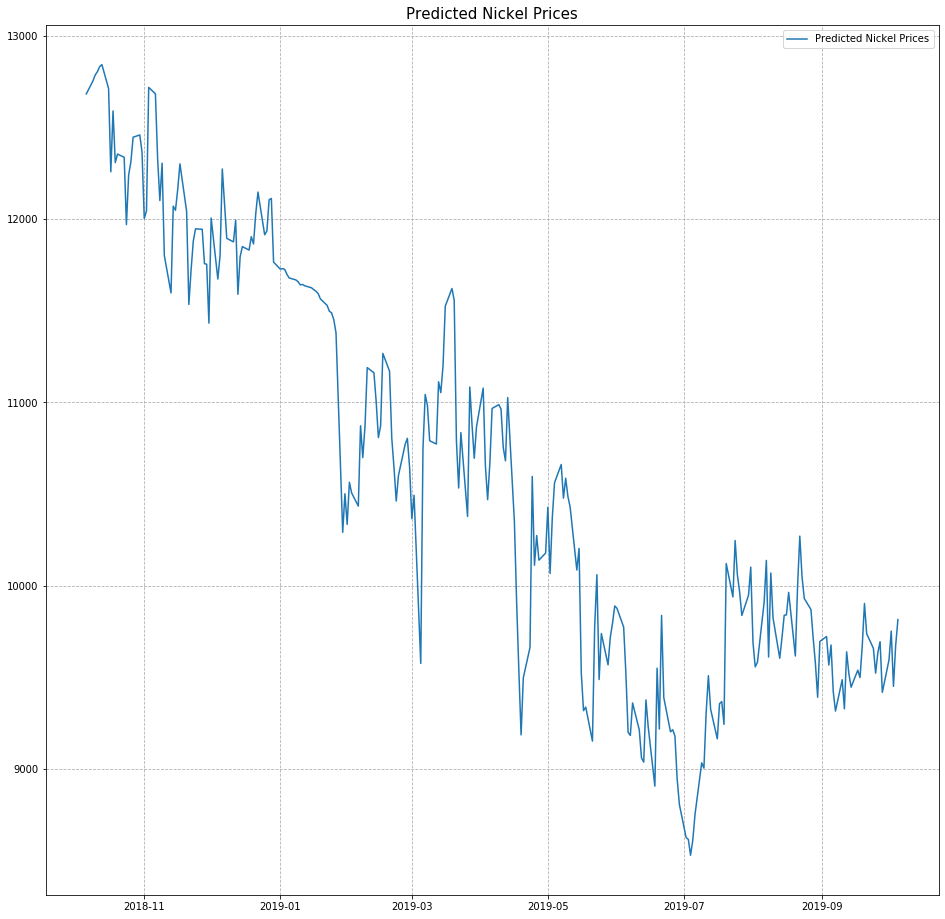

In [105]:
results = unscaled.copy()
results.index = results.index + pd.DateOffset(years=1)

plt.plot(results)
#plt.gridlines(True)
#unscaled.head(30)

plt.title('Predicted Nickel Prices', fontsize=15)
#plt.axhline(df_results['results'].mean(), color='r', linestyle='dotted')
plt.legend(['Predicted Nickel Prices'])
plt.grid(linestyle='dashed')
plt.show()

In [69]:
# To save prediction results to a pickle file

from datetime import datetime
now = datetime.now()

timestamp = datetime.timestamp(now)
timestamp = datetime.fromtimestamp(timestamp)

# To save as a csv data type
results.to_csv('forecasts_'+str(timestamp)[:10] + '.csv', header=True)

print(timestamp)

2019-11-25 13:28:23.861677


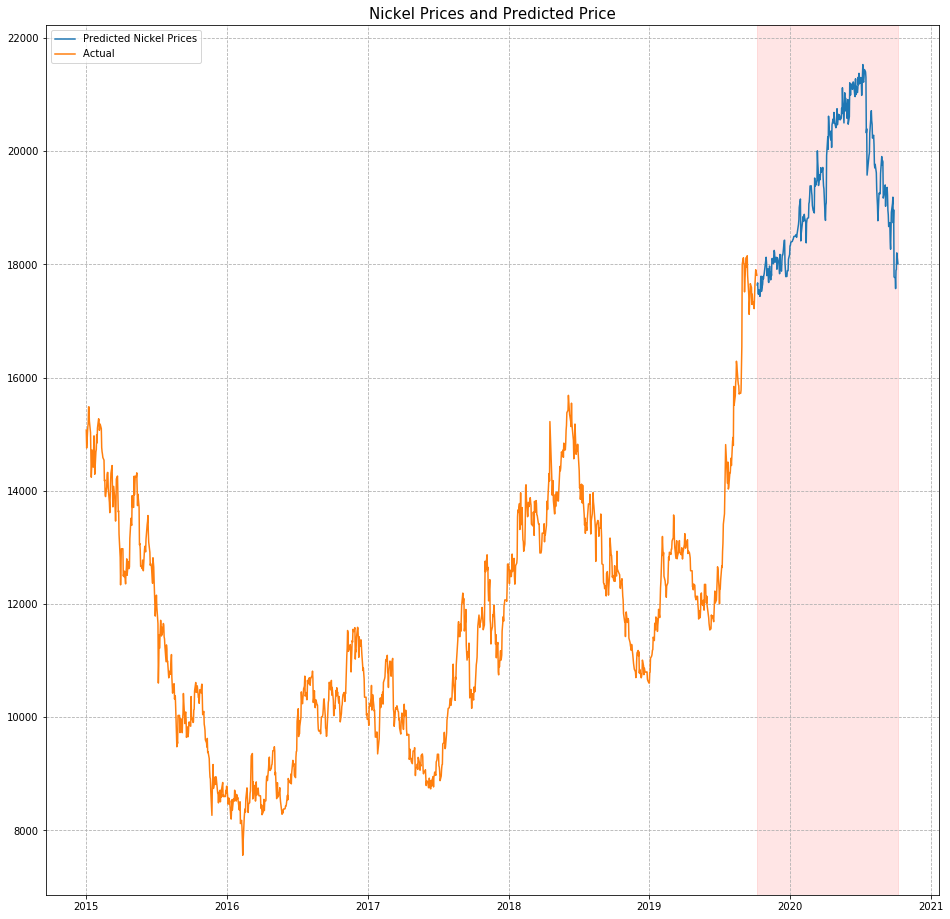

In [70]:
plt.plot(results)
plt.plot(LME[LME.index.year > 2014])

#plt.plot(LME)
rcParams['figure.figsize'] = 16, 16


plt.grid(linestyle='dashed')
plt.legend(['Predicted Nickel Prices', 'Actual '])
plt.axvspan(results.index[0], results.index[-1], alpha=0.1, color='red')
plt.title('Nickel Prices and Predicted Price', fontsize=15)

plt.show()


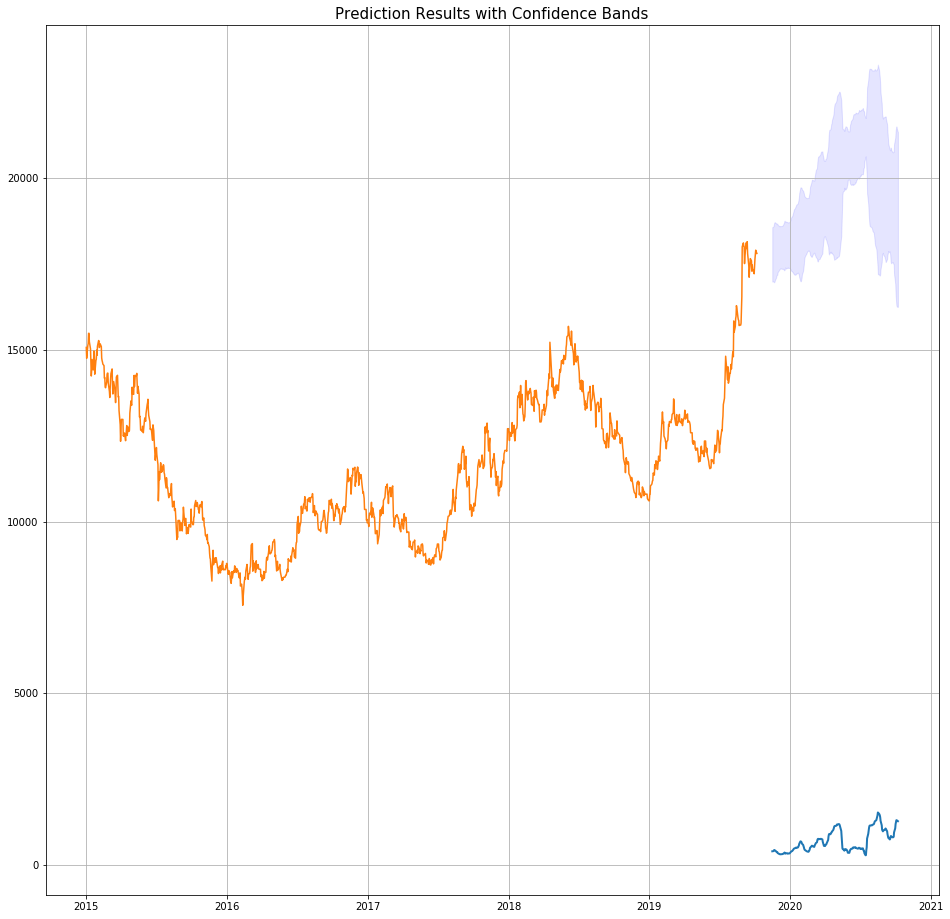

In [71]:
time_series_df = pd.DataFrame(results)
smooth_path    = time_series_df.rolling(30).mean()
path_deviation = 2 * time_series_df.rolling(30).std()
plt.plot(path_deviation, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
plt.grid()
plt.title('Prediction Results with Confidence Bands', fontsize=15)
plt.plot(LME[LME.index.year > 2014])

plt.show()

In [61]:
smooth_path

,0
ds,
2019-10-08,NaN
2019-10-09,NaN
2019-10-10,NaN
2019-10-11,NaN
2019-10-12,NaN
2019-10-15,NaN
2019-10-16,NaN
2019-10-17,NaN
2019-10-18,NaN


Timestamp('2019-10-08 00:00:00')

2019-11-24 20:51:07.001921


## Next Task: Create Visualizations for Predicted and previous values 

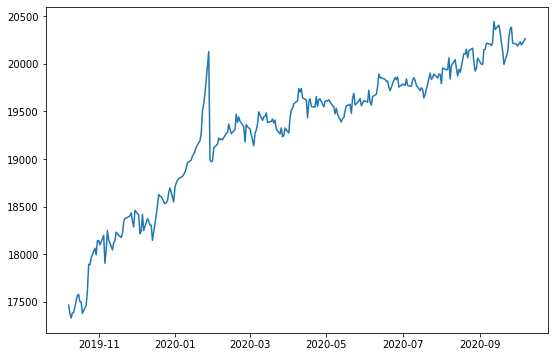

In [44]:
plt.plot(results)


2019-10-01    17434.0
2019-10-02    17640.0
2019-10-03    17775.0
2019-10-04    17906.0
2019-10-07    17810.0
Freq: B, Name: Cash Price ($/MT), dtype: float64

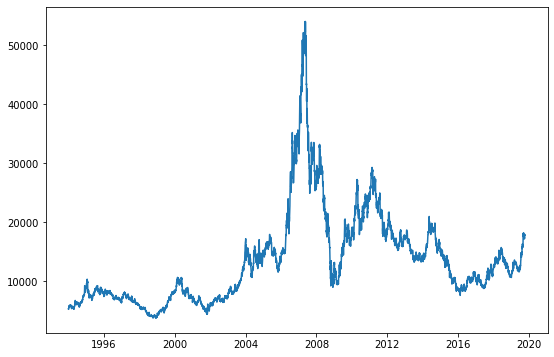

In [48]:
plt.plot(LME)

LME.tail()

In [59]:
y_pred = unscaled

print(y_pred)


#y_lower = np.percentile(y_pred, 10)

#print(y_lower)
#y_higher = np.percentile(y_Pred, 90)
#y_mid = np.percentile(y_pred, 50)

ds
2018-10-08    17534.786229
2018-10-09    17541.409862
2018-10-10    17574.645398
2018-10-11    17494.281269
2018-10-12    17537.562706
2018-10-15    17564.122197
2018-10-16    17631.015595
2018-10-17    17674.201332
2018-10-18    17852.590636
2018-10-19    17178.460634
2018-10-22    17834.034937
2018-10-23    17630.692828
2018-10-24    17422.425986
2018-10-25    17090.162540
2018-10-26    17004.528506
2018-10-29    17256.064889
2018-10-30    17714.567286
2018-10-31    17555.436540
2018-11-01    17812.865570
2018-11-02    17492.100374
2018-11-05    17350.381452
2018-11-06    16930.917569
2018-11-07    17245.440200
2018-11-08    17396.596678
2018-11-09    17844.675796
2018-11-12    17497.611747
2018-11-13    17850.273936
2018-11-14    17684.969904
2018-11-15    18285.868714
2018-11-16    18150.118847
                  ...     
2019-08-27    18386.798281
2019-08-28    18548.640353
2019-08-29    18242.916031
2019-08-30    17652.135329
2019-09-02    17949.180479
2019-09-03    17876.24239

In [39]:
# Confidence Interval Time Series From tutorial https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/validating-and-inspecting-time-series-models?ex=12

# Bootstrapping TUtorial Statistics
# https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/bootstrap-confidence-intervals?ex=5

n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
# Compute the percentiles of choice for the bootstrapped means
percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)

#conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})
conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})


In [44]:
print(bootstrap_means)

[[18456.84378109 18456.84378109 18456.84378109 ... 18456.84378109
  18456.84378109 18456.84378109]
 [18461.94082895 18461.94082895 18461.94082895 ... 18461.94082895
  18461.94082895 18461.94082895]
 [18590.67147797 18590.67147797 18590.67147797 ... 18590.67147797
  18590.67147797 18590.67147797]
 ...
 [18459.25407789 18459.25407789 18459.25407789 ... 18459.25407789
  18459.25407789 18459.25407789]
 [18529.62445989 18529.62445989 18529.62445989 ... 18529.62445989
  18529.62445989 18529.62445989]
 [18570.15957174 18570.15957174 18570.15957174 ... 18570.15957174
  18570.15957174 18570.15957174]]


In [37]:
n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
    print('random sample: ', random_sample)
    print()
    print('calculated mean', random_sample.mean(axis=0))
    print()

random sample:  ds
2018-11-28    17625.593422
2019-02-27    18356.570512
2019-01-29    18358.778301
2019-02-25    19034.772323
2018-12-31    18046.456536
2019-09-20    17549.608819
2018-12-13    18468.833320
2019-07-10    19789.626166
2018-11-29    18170.158469
2019-08-22    17548.826393
2019-05-30    19447.173936
2019-08-21    17887.554343
2019-09-09    18080.648368
2019-03-15    18480.482787
2018-10-11    17494.281269
2019-02-12    18403.477579
2019-02-11    18602.477223
2019-06-28    20132.671710
2018-12-06    18010.799320
2019-03-29    18336.212843
2019-05-02    19321.039420
2019-02-07    18691.143417
2019-06-06    19718.558893
2019-05-23    19395.219011
2019-09-23    17331.690037
2019-04-29    19082.124611
2019-01-25    18784.746840
2019-02-12    18403.477579
2019-02-26    18858.522699
2019-09-16    17538.842278
                  ...     
2019-06-05    19759.973145
2018-11-12    17497.611747
2019-04-17    19170.780500
2019-06-11    19867.582422
2019-09-24    17284.894348
2019-06-2


random sample:  ds
2019-07-12    19982.504484
2019-07-25    18394.101326
2019-04-12    18985.278629
2019-01-15    18497.854885
2019-03-26    18742.749200
2019-03-14    18378.962986
2019-02-19    18694.148427
2019-07-01    20287.408751
2019-07-09    19792.634979
2019-09-30    16413.433836
2019-09-13    17389.691705
2019-08-14    17528.843131
2019-08-16    17430.142103
2019-03-29    18336.212843
2018-12-03    18180.276105
2019-09-12    17660.225321
2018-10-10    17574.645398
2018-11-27    18371.351862
2019-01-29    18358.778301
2019-01-21    18563.399146
2019-07-08    20452.302151
2019-07-29    18847.099827
2019-05-13    19488.879305
2019-07-25    18394.101326
2019-01-04    18461.616093
2018-10-30    17714.567286
2019-04-15    18882.258251
2018-11-08    17396.596678
2018-12-04    18029.378041
2019-07-29    18847.099827
                  ...     
2019-06-04    19836.085132
2019-01-24    18755.643119
2019-09-10    17798.327390
2019-08-05    19115.069366
2018-10-23    17630.692828
2018-10-

In [35]:
bootstrap_means = np.zeros((n_boots, len(y_pred)))
bootstrap_means.shape

(100, 261)

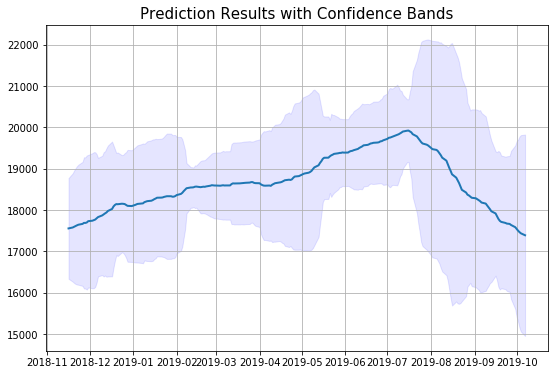

In [25]:
# From https://stackoverflow.com/questions/50161140/how-to-plot-a-time-series-array-with-confidence-intervals-displayed-in-python

time_series_df = pd.DataFrame(y_pred)
smooth_path    = time_series_df.rolling(30).mean()
path_deviation = 2 * time_series_df.rolling(30).std()
plt.plot(smooth_path, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
plt.grid()
plt.title('Prediction Results with Confidence Bands', fontsize=15)
plt.show()

In [44]:
for date in dates:
    print(date)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


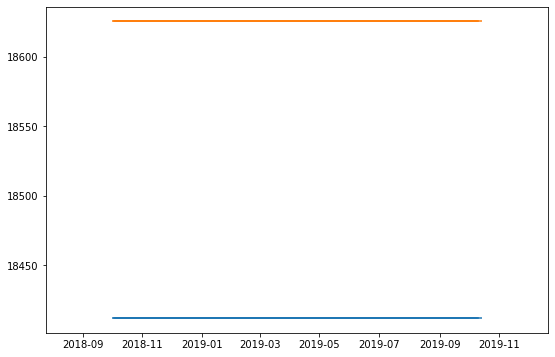

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_pred.index, percentiles[0], marker='_', s=200)
ax.scatter(y_pred.index, percentiles[1], marker='_', s=200)

In [30]:
def my_corrcoef(est, X, y):
    """Return the correlation coefficient
    between model predictions and a validation set."""
    return np.corrcoef(y, est.predict(X))[1, 0]
# Grab the date of the first index of each validation set
first_indices = [data.index[tt[0]] for tr, tt in cv.split(X, y)]
# Calculate the CV scores and convert to a Pandas Series
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=my_corrcoef)
cv_scores = pd.Series(cv_scores, index=first_indices)



fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# Calculate a rolling mean of scores over time
cv_scores_mean = cv_scores.rolling(10, min_periods=1).mean()
cv_scores.plot(ax=axs[0])
axs[0].set(title='Validation scores (correlation)', ylim=[0, 1])
# Plot the raw data
data.plot(ax=axs[1])
axs[1].set(title='Validation data')

NameError: name 'cv' is not defined

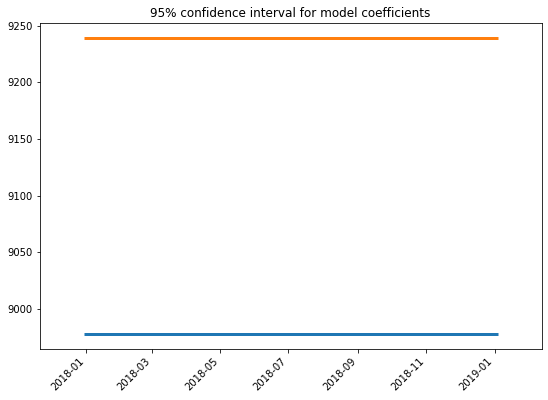

In [93]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(y_pred)

# Plot it
fig, ax = plt.subplots()
ax.scatter(y_pred.index, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(y_pred.index, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
# bootstrap for mean
boot_means = []
for _ in range(100):
    bootsample = np.random.choice(sample,size=30, replace=True)
    boot_means.append(bootsample.mean())